# Librerías

In [ ]:
#%pip install tensorflow==1.9 #2.1
%pip install -U tensorflow
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
%pip install keras-tcn

%pip install numpy==1.19.5
#%pip install -U numpy==1.18.5
%pip install pycocotools==2.0.0

%matplotlib inline
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPool1D, LSTM, Input, GRU, Conv2D, MaxPool2D
from tensorflow.keras import backend as K
from tcn import TCN
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import style
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
import statsmodels.api as sm
import statsmodels.formula.api as smf
import datetime
import random
import math
import csv

%pip install apyori
from apyori import apriori

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 578.0 MB 18 kB/s 
     |████████████████████████████████| 1.7 MB 61.9 MB/s 
     |████████████████████████████████| 438 kB 63.7 MB/s 
     |████████████████████████████████| 5.9 MB 59.6 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 31.4 MB/s 
  Created wheel for pycocotools: filename=pycocotools-2.0.0-cp37-cp37m-linux_x86_64.whl size=264530 sha256=e95934281bccc750540be9eab268a9f6c5d8f325b4bcf7ddd1cef9c30a3fd3e7
  Stored in directory: /root/.cache/pip/wheels/4d/50/dc/e1f07e9eb5678a0ee21bc091220f1f3806ba8e48ef3f2083cb
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.5
    Uninstalling pycocotools-2.0.5:
      Successfully uninstalled pycocotools-2.0.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for apyori: filename=apyori-1.1.2-py3-none-any.whl size=5974 sha256=a653b276b806bff6ba27bfa1429e2d7d9b7ab1426d29814563911400757007d8
  Stored in directory: /root/.cache/pip/wheels/cb/f6/e1/57973c631d27efd1a2f375bd6a83b2a616c4021f24aab84080
Succes

In [ ]:
# Fix random seed to allow reproducible experiments
np.random.seed(1)
tf.random.set_seed(1)
random.seed(1)

# Gráfico de predicción

In [ ]:
colors = plt.get_cmap('Set2', 10)

def show_plot(x, y, y_pred=None):
  fig, ax = plt.subplots(1,1, figsize=(15,5))
  ax.plot(x, 'o-', c=colors(3), markersize=3.5, label='History')
  ax.plot([m for m in range(x.shape[0],x.shape[0]+y.shape[0])], y, 'x-', c=colors(0), markersize=3.5, label='True Future')
  if y_pred is not None:
    ax.plot([m for m in range(x.shape[0],x.shape[0]+y.shape[0])], y_pred, 'o-', c=colors(2), markersize=3.5, label='Model prediction')
  ax.legend()

# Series temporales

## Temperatura en San Francisco

In [ ]:
!mkdir data
!wget -O data/test.csv https://www.dropbox.com/s/a7vocgb6vja8m3n/test.csv?dl=1
!wget -O data/train.csv https://www.dropbox.com/s/eustrvj0bkn27cm/train.csv?dl=1

--2022-10-07 09:39:33--  https://www.dropbox.com/s/a7vocgb6vja8m3n/test.csv?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/a7vocgb6vja8m3n/test.csv [following]
--2022-10-07 09:39:34--  https://www.dropbox.com/s/dl/a7vocgb6vja8m3n/test.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc281024fc38ae51678c015dd856.dl.dropboxusercontent.com/cd/0/get/BuXBQkWAp0vjvIxWIl9-iAJtb28thYmrE6E_kL1OhusREQb9Ijso8a190-gidNpe4ccjcKjaGJODadrity0nUKHXlWSmBYMPk8cQixSiAGK6iw4A1uKkEKFtmwhRFgdg7LQtAzG6X_YhK2n3PFwQ1oTIiuTqnsKooCZ25NGkPmDDhV7-BGlLJ6WUxE-tVpiDH74/file?dl=1# [following]
--2022-10-07 09:39:34--  https://uc281024fc38ae51678c015dd856.dl.dropboxusercontent.com/cd/0/get/BuXBQkWAp0vjvIxWIl9-iAJtb28thYmrE6E_kL1OhusREQb9Ijso8a190-gidNpe4c

In [ ]:
# Read training set
train_filename = 'data/train.csv'
with open(train_filename, 'r') as datafile:
  ts_list_train = datafile.readlines()
  ts_list_train = np.asarray([np.asarray(l.rstrip().split(','), dtype=np.float32) for l in ts_list_train])

# Read test set
test_filename = 'data/test.csv'
with open(test_filename, 'r') as datafile:
  ts_list_test = datafile.readlines()
  ts_list_test = np.asarray([np.asarray(l.rstrip().split(','), dtype=np.float32) for l in ts_list_test])

headers = ['San Francisco']
initial_moment = datetime.datetime(2012, 10, 1, 13,0)
#colors = plt.get_cmap('Set3', len(headers))

In [ ]:
PH = 240 # 240
FH = 24 # 24

## Generación de energía eólica en España

In [ ]:
!mkdir data
!wget -O data/data.csv https://www.dropbox.com/s/2o68sl7q6dcv156/data_no_timestamp.csv?dl=1

mkdir: cannot create directory ‘data’: File exists
--2022-09-27 10:24:24--  https://www.dropbox.com/s/2o68sl7q6dcv156/data_no_timestamp.csv?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/2o68sl7q6dcv156/data_no_timestamp.csv [following]
--2022-09-27 10:24:24--  https://www.dropbox.com/s/dl/2o68sl7q6dcv156/data_no_timestamp.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd7bf4b6015de32b39c10bdef44.dl.dropboxusercontent.com/cd/0/get/Btsd0NzSJ4XsB3GhSSbeKuS973s4ey1h2RYNUJt6LVIVIqr_cC4LIVgQKFlD4ymA4yztFSb165Q83yAX7O2Aurm1MflTvB9Gzqb-59ao5nDQVw3vvzmf-3LrcyaiE1LvAsrjBhCxqgq6yPLsabcDEqNd6OHGYXYzVjtXwDpZd-qyduGNRa8VzTUtckdD77BAEZw/file?dl=1# [following]
--2022-09-27 10:24:24--  https://ucd7bf4b6015de32b39c10bdef44.dl.dropboxuser

In [ ]:
PH = 365 # 365
FH = 4 # 4

In [ ]:
data_filename = 'data/data.csv'
with open(data_filename, 'r') as datafile:
  ts_list_data = datafile.readlines()
  ts_list_data = np.asarray([np.asarray(l.rstrip().split(',')[1], dtype=np.float32) for l in ts_list_data])

#cut = int(len(ts_list_data) * 0.8)
cut = len(ts_list_data) - FH

ts_list_train = ts_list_data[:cut]
ts_list_test = ts_list_data[cut:]

ts_list_train = np.asarray([ts_list_train])
ts_list_test = np.asarray([ts_list_test])

headers = ['España']
initial_moment = datetime.datetime(2014, 1, 1, 0,0)
#colors = plt.get_cmap('Set3', len(headers))

## Generación de energía solar en España

### Intervalo 10 minutos

In [ ]:
!mkdir data
!wget -O data/data.csv https://www.dropbox.com/s/hohs1gr0h9pzvek/dataset10m.csv?dl=1

--2022-08-08 11:22:21--  https://www.dropbox.com/s/hohs1gr0h9pzvek/dataset10m.csv?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/hohs1gr0h9pzvek/dataset10m.csv [following]
--2022-08-08 11:22:21--  https://www.dropbox.com/s/dl/hohs1gr0h9pzvek/dataset10m.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd3481ce40663c31b47f66a50cc.dl.dropboxusercontent.com/cd/0/get/Bqn3zcDtDAPMv_vkpT3KM3IjMFwkuippPGy4ykqrJHsz96vINsHjIorpFWoexf0ALwUQZIyUUjBwKZT9MVwZyGm0TDjFwQ3OgVp2eHFXrnX7AMEHhPDYlv8FeaZJae_ezA_A5EDvI25PmyhUQuzjTdeOsbQ8jGBRjxEMNrQcSvYqpmJvUDchGHRn-T1lo5TOTkY/file?dl=1# [following]
--2022-08-08 11:22:21--  https://ucd3481ce40663c31b47f66a50cc.dl.dropboxusercontent.com/cd/0/get/Bqn3zcDtDAPMv_vkpT3KM3IjMFwkuippPGy4ykq

In [ ]:
PH = 365 # 365
FH = 4 # 4

In [ ]:
data_filename = 'data/data.csv'
with open(data_filename, 'r') as datafile:
  ts_list_data = datafile.readlines()
  ts_list_data = np.asarray([np.asarray(l.rstrip().split(',')[1], dtype=np.float32) for l in ts_list_data])

#cut = int(len(ts_list_data) * 0.8)
cut = len(ts_list_data) - FH

ts_list_train = ts_list_data[:cut]
ts_list_test = ts_list_data[cut:]

ts_list_train = np.asarray([ts_list_train])
ts_list_test = np.asarray([ts_list_test])

headers = ['España']
initial_moment = datetime.datetime(2014, 1, 1, 0,0)
#colors = plt.get_cmap('Set3', len(headers))

### Intervalo 1 hora

In [ ]:
!mkdir data
!wget -O data/data.csv https://www.dropbox.com/s/axfbmqdcpquqqun/dataset_solar_1h.csv?dl=1

mkdir: cannot create directory ‘data’: File exists
--2022-09-27 10:54:39--  https://www.dropbox.com/s/axfbmqdcpquqqun/dataset_solar_1h.csv?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/axfbmqdcpquqqun/dataset_solar_1h.csv [following]
--2022-09-27 10:54:40--  https://www.dropbox.com/s/dl/axfbmqdcpquqqun/dataset_solar_1h.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc453b36d6b5ae5f895a790026e.dl.dropboxusercontent.com/cd/0/get/Btv51V4HtDvHwuShnyc77EuTjy26uKN9TfYtNA305n3qrxIxyk8IJ_ymXMBNPisJyb0UxIonWrRsg4etPFh3vGbPLudmT8JWdXr4X1rReCmm_nF0XLKXtTB0tO-BcpnVzx1mvbL33-YApRNvKoM3e1oydMqZEhdkoB4oYdbyw5bLGv4SfMnr9r04Y_CIJAXo3M8/file?dl=1# [following]
--2022-09-27 10:54:40--  https://ucc453b36d6b5ae5f895a790026e.dl.dropboxusercon

In [ ]:
PH = 48 # 365
FH = 1 # 6

In [ ]:
data_filename = 'data/data.csv'
with open(data_filename, 'r') as datafile:
  ts_list_data = datafile.readlines()
  ts_list_data = np.asarray([np.asarray(l.rstrip().split(',')[1], dtype=np.float32) for l in ts_list_data])

#cut = int(len(ts_list_data) * 0.8)
cut = len(ts_list_data) - FH

ts_list_train = ts_list_data[:cut]
ts_list_test = ts_list_data[cut:]

ts_list_train = np.asarray([ts_list_train])
ts_list_test = np.asarray([ts_list_test])

headers = ['España']
initial_moment = datetime.datetime(2014, 1, 1, 0,0)
#colors = plt.get_cmap('Set3', len(headers))

## Derechos de generación de CO2 (EUAs)

In [ ]:
!mkdir data
!wget -O data/data.csv https://www.dropbox.com/s/qgofdhw2ij3ornk/dataset.csv?dl=1

In [ ]:
PH = 365 # 365
FH = 2 # 2

In [ ]:
data_filename = 'data/data.csv'
with open(data_filename, 'r') as datafile:
  ts_list_data = datafile.readlines()
  ts_list_data = np.asarray([np.asarray(float(l.rstrip().split(';')[1].replace(",", ".")), dtype=np.float32) for l in ts_list_data])

#cut = int(len(ts_list_data) * 0.8)
cut = len(ts_list_data) - FH

ts_list_train = ts_list_data[:cut]
ts_list_test = ts_list_data[cut:]

ts_list_train = np.asarray([ts_list_train])
ts_list_test = np.asarray([ts_list_test])

headers = ['EUAs']
initial_moment = datetime.datetime(2014, 1, 1, 0,0)
#colors = plt.get_cmap('Set3', len(headers))

## Tráfico Web Wikipedia

In [ ]:
!mkdir data
!wget -O data/test.csv https://www.dropbox.com/s/d8mtob2rqnw9l44/test.csv?dl=1
!wget -O data/train.csv https://www.dropbox.com/s/ielwrdur3eg08rv/train.csv?dl=1

--2022-08-18 08:49:38--  https://www.dropbox.com/s/d8mtob2rqnw9l44/test.csv?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/d8mtob2rqnw9l44/test.csv [following]
--2022-08-18 08:49:39--  https://www.dropbox.com/s/dl/d8mtob2rqnw9l44/test.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucab9ed08c9b5f9dac5e971dfcf5.dl.dropboxusercontent.com/cd/0/get/BrOoAJcIux7852Edz2CXC1oq0g7Hpff-Hlh2Wh77PpY3T9Yoj9KSEm6PgMAeocJgBLJxo-rE9XqLwPq_H7nm5QTh8bIJWW6iVixMrko1YOSZg4bFfhOoi9buO4rpifTRzbEfYBXh41f3tNCzn81gm21jw_uLsBhjnePT0rI7YjmN5fnRIICaEn7OHH2kX2OPUOs/file?dl=1# [following]
--2022-08-18 08:49:39--  https://ucab9ed08c9b5f9dac5e971dfcf5.dl.dropboxusercontent.com/cd/0/get/BrOoAJcIux7852Edz2CXC1oq0g7Hpff-Hlh2Wh77PpY3T9Yoj9KSEm

In [ ]:
# Read training set
train_filename = 'data/train.csv'
with open(train_filename, 'r') as datafile:
  ts_list_train = datafile.readlines()
  ts_list_train = np.asarray([np.asarray(l.rstrip().split(','), dtype=np.float32) for l in ts_list_train])

# Read test set
test_filename = 'data/test.csv'
with open(test_filename, 'r') as datafile:
  ts_list_test = datafile.readlines()
  ts_list_test = np.asarray([np.asarray(l.rstrip().split(','), dtype=np.float32) for l in ts_list_test])

#headers = ['San Francisco']
#initial_moment = datetime.datetime(2012, 10, 1, 13,0)

In [ ]:
PH = 74 # 74
FH = 59 # 59

## Ratio de intercambios - Australia

In [ ]:
!mkdir data
!wget -O data/test.csv https://www.dropbox.com/s/0x0ewgen1jzqsuz/test.csv?dl=1
!wget -O data/train.csv https://www.dropbox.com/s/gkb49sah7mkqgqo/train.csv?dl=1

--2022-08-19 11:40:25--  https://www.dropbox.com/s/0x0ewgen1jzqsuz/test.csv?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/0x0ewgen1jzqsuz/test.csv [following]
--2022-08-19 11:40:25--  https://www.dropbox.com/s/dl/0x0ewgen1jzqsuz/test.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucad37203eac41d5602ad807ea03.dl.dropboxusercontent.com/cd/0/get/BrQEIFvgUso802tsPnSFqy27w-Zg4s4wVgQ5t5JR9O-kI2K6H1ecSPtcaKQgfgW9G8yD6LCzK4De2QKpKUtzYzHCxfQq8ccKZmXEN2GK54oXe1T06QKpeDb801Xh80ZEmvVKXQe6gclbKzJcI0T3ybobthEdkemd1QWlkWHRzn6FRO7_1fyMGF5LIx2n7ctY89Q/file?dl=1# [following]
--2022-08-19 11:40:25--  https://ucad37203eac41d5602ad807ea03.dl.dropboxusercontent.com/cd/0/get/BrQEIFvgUso802tsPnSFqy27w-Zg4s4wVgQ5t5JR9O-kI2K6H1ecSP

In [ ]:
# Read training set
train_filename = 'data/train.csv'
with open(train_filename, 'r') as datafile:
  ts_list_train = datafile.readlines()
  ts_list_train = np.asarray([np.asarray(l.rstrip().split(','), dtype=np.float32) for l in ts_list_train])

# Read test set
test_filename = 'data/test.csv'
with open(test_filename, 'r') as datafile:
  ts_list_test = datafile.readlines()
  ts_list_test = np.asarray([np.asarray(l.rstrip().split(','), dtype=np.float32) for l in ts_list_test])

headers = ['Australia']
initial_moment = datetime.datetime(1990, 1, 1, 0,0)

In [ ]:
PH = 365 # 365
FH = 6 # 6

## Retiro efectivo ATM

In [ ]:
!mkdir data
!wget -O data/test.csv https://www.dropbox.com/s/u7wgfn8znupe0w5/test.csv?dl=1
!wget -O data/train.csv https://www.dropbox.com/s/gvigdibfgtigegs/train.csv?dl=1

--2022-08-23 10:16:17--  https://www.dropbox.com/s/u7wgfn8znupe0w5/test.csv?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/u7wgfn8znupe0w5/test.csv [following]
--2022-08-23 10:16:18--  https://www.dropbox.com/s/dl/u7wgfn8znupe0w5/test.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0daf083dffaaaa7c101c11cb6a.dl.dropboxusercontent.com/cd/0/get/Brh19LuItxq8YfOOhfgQwLIy95uFyENid77ASY-3PeqMy6Scwz2kIiI5VSCOg4M4kjEWFWah1VrG0ouv6aD_XnfuVvDjdpvq84KFP0wHLUxdeC6MqgBJvhBepvDEOXCcUu9DGMkDahda5LINzy21mOdkXsmXfCPTuJsWrMGaG2e6g3X0LYvrH_kOLKFHEoDZLOY/file?dl=1# [following]
--2022-08-23 10:16:18--  https://uc0daf083dffaaaa7c101c11cb6a.dl.dropboxusercontent.com/cd/0/get/Brh19LuItxq8YfOOhfgQwLIy95uFyENid77ASY-3PeqMy6Scwz2kIi

In [ ]:
# Read training set
train_filename = 'data/train.csv'
with open(train_filename, 'r') as datafile:
  ts_list_train = datafile.readlines()
  ts_list_train = np.asarray([np.asarray(l.rstrip().split(','), dtype=np.float32) for l in ts_list_train])

# Read test set
test_filename = 'data/test.csv'
with open(test_filename, 'r') as datafile:
  ts_list_test = datafile.readlines()
  ts_list_test = np.asarray([np.asarray(l.rstrip().split(','), dtype=np.float32) for l in ts_list_test])

headers = ['Inglaterra']
#initial_moment = datetime.datetime(1990, 1, 1, 0,0)

In [ ]:
PH = 70 # 70
FH = 56 # 56

# Inicialización y estratégia de ventana

In [ ]:
from collections import defaultdict
results = defaultdict(lambda: {})

def normalize(ts, norm_params):
  """
  Apply min-max normalization
  :param data: time series
  :param norm_params: tuple with params mean, std, max, min
  :return: normalized time series
  """
  return (ts - norm_params['min']) / (norm_params['max'] - norm_params['min'])

#Let's normalize the data.
ts_list_train_norm = []
# Save training norm params in order to use it for the test data 
norm_params_list = []

for ts in ts_list_train:
  norm_params = {}
  norm_params['mean'] = ts.mean()
  norm_params['std'] = ts.std()
  norm_params['max'] = ts.max()
  norm_params['min'] = ts.min()
  norm_params_list.append(norm_params)

  ts_norm = normalize(ts, norm_params)
  ts_list_train_norm.append(ts_norm)

# Lets normalize the test data
ts_list_test_norm = []
for i, ts in enumerate(ts_list_test):
  norm_params = norm_params_list[i]
  ts_norm = normalize(ts, norm_params)
  ts_list_test_norm.append(ts_norm)

past_history = PH
forecast_horizon = FH

# Moving window strategy

x_train, y_train = [], []
x_test, y_test = [], []

for i, ts in enumerate(ts_list_train_norm):
  # Train data
  ts_x_train, ts_y_train = [], []
  for j in range(0, ts.shape[0] - forecast_horizon + 1):
    indices = range(j - past_history, j, 1)
    # Reshape data from (past_history,) to (past_history, 1)
    ts_x_train.append(np.reshape(ts[indices], (past_history, 1)))
    ts_y_train.append(ts[j:j + forecast_horizon])
  x_train.extend(np.asarray(ts_x_train))
  y_train.extend(np.asarray(ts_y_train))
  # Test data
  ts_x_test = np.reshape(np.asarray(ts[-past_history:]), (past_history, 1))
  ts_y_test=  ts_list_test_norm[i]
  x_test.extend(np.asarray([ts_x_test]))
  y_test.extend(np.asarray([ts_y_test]))

x_train, y_train = np.asarray(x_train), np.asarray(y_train)
x_test, y_test = np.asarray(x_test), np.asarray(y_test, dtype='float32')

# Temporal Convolutional Network - TCN

In [ ]:
# TCN

inp = Input(shape=x_train.shape[-2:])
x = TCN(nb_filters=64, kernel_size=3, nb_stacks=1, dilations=[1,2,4,8,16,32,64])(inp)
x = Dense(forecast_horizon)(x)
model = keras.Model(inputs=inp, outputs=x)

model.compile(optimizer='adam', loss='mae')
print(model.summary())

history = model.fit(x_train, y_train,
        batch_size=256, #Cambiar tamaño batch size a x_train
        epochs=5,
        verbose=5,
        validation_data=(x_test, y_test))


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 240, 1)]          0         
                                                                 
 tcn_4 (TCN)                 (None, 64)                160960    
                                                                 
 dense_4 (Dense)             (None, 24)                1560      
                                                                 
Total params: 162,520
Trainable params: 162,520
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5


# Long-Short Term Memory - LSTM

In [ ]:
#LSTM

inp = Input(shape=x_train.shape[-2:])
x = LSTM(64, return_sequences=True)(inp)
x = LSTM(32, return_sequences=False)(x)
x = Dense(64)(x)
x = Dense(forecast_horizon)(x)
model = keras.Model(inputs=inp, outputs=x)

model.compile(optimizer='adam', loss='mae')
print(model.summary())

history = model.fit(x_train, y_train,
          batch_size=256,
          epochs=5,
          verbose=1,
          validation_data=(x_test, y_test))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 70, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 70, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 56)                3640      
                                                                 
Total params: 35,064
Trainable params: 35,064
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
3/3 [==============================] - 7s 

# Gated Recurrent Unit - GRU

In [ ]:
# GRU
inp = Input(shape=x_train.shape[-2:])
x = GRU(128, return_sequences=True)(inp)
x = GRU(64, return_sequences=True)(x)
x = Flatten()(x)
x = Dense(64)(x)
x = Dense(forecast_horizon)(x)
model = keras.Model(inputs=inp, outputs=x)

model.compile(optimizer='adam', loss='mae')
print(model.summary())

history = model.fit(x_train, y_train,
          batch_size=256,
          epochs=5,
          verbose=1,
          validation_data=(x_test, y_test))

# Convolutional Neural Network - CNN

In [ ]:
# CNN
inp = Input(shape=x_train.shape[-2:])
x = Conv1D(128, 7, activation='relu', padding='same')(inp)
x = MaxPool1D(pool_size=2)(x)
x = tf.keras.layers.Conv1D(64, 5, activation='relu', padding='same')(inp)
x = tf.keras.layers.MaxPool1D(pool_size=2)(x)
x = tf.keras.layers.Flatten()(x)
x = Dense(forecast_horizon)(x)
model = keras.Model(inputs=inp, outputs=x)

model.compile(optimizer='adam', loss='mae')
print(model.summary())

history = model.fit(x_train, y_train,
          batch_size=256,
          epochs=5,
          verbose=1,
          validation_data=(x_test, y_test))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 365, 1)]          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 365, 64)           384       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 182, 64)          0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 11648)             0         
                                                                 
 dense (Dense)               (None, 6)                 69894     
                                                                 
Total params: 70,278
Trainable params: 70,278
Non-trainable params: 0
_________________________________________________________

# Multi-Layer Perceptron - MLP

In [ ]:
# MLP
inp = Input(shape=x_train.shape[-2:])
x = Flatten()(inp)
x = Dense(128)(x)
x = Dense(64)(x)
x = Dense(32)(x)
x = Dense(forecast_horizon)(x)
model = keras.Model(inputs=inp, outputs=x)

model.compile(optimizer='adam', loss='mae')

history = model.fit(x_train, y_train,
          batch_size=256,
          epochs=5,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 44413 samples, validate on 1 samples
Epoch 1/5
44413/44413 [==============================] - 1s 31us/sample - loss: 0.0819 - val_loss: 0.0419
Epoch 2/5
44413/44413 [==============================] - 1s 21us/sample - loss: 0.0441 - val_loss: 0.0260
Epoch 3/5
44413/44413 [==============================] - 1s 24us/sample - loss: 0.0407 - val_loss: 0.0242
Epoch 4/5
44413/44413 [==============================] - 1s 24us/sample - loss: 0.0384 - val_loss: 0.0227
Epoch 5/5
44413/44413 [==============================] - 2s 35us/sample - loss: 0.0385 - val_loss: 0.0211


# Linear Regression - LN

In [ ]:
#LN

model = LinearRegression()

x_train_m = []
i = 0
j = 0
for a in x_train:
  x_train_m.append([])
  for b in a:
    for c in b:
      x_train_m[i].append(c)
  i += 1

history = model.fit(x_train_m, y_train)

In [ ]:
x_test_m = []
i = 0
j = 0
for a in x_test:
  x_test_m.append([])
  for b in a:
    for c in b:
      x_test_m[i].append(c)
  i += 1

x_test = np.asarray(x_test_m)

# Predicción caso base

1/1 [==============================] - 0s 392ms/step
TCN    0.034342
Name: MAE, dtype: float32


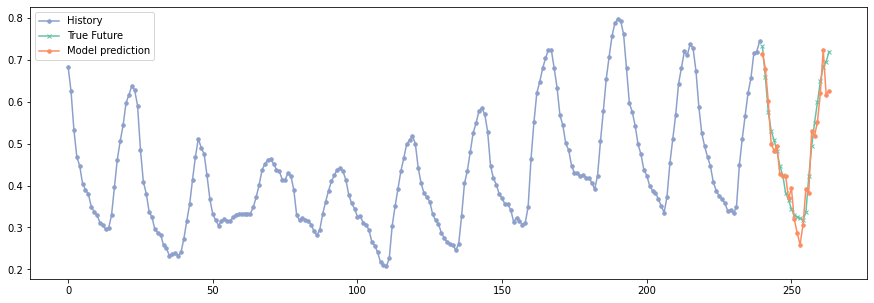

In [ ]:
predictions = model.predict(x_test)
mae = mean_absolute_error(y_test, predictions)
results['MAE']['TCN'] = mae
results['Y_PRED']['TCN'] = predictions
print(pd.DataFrame(results)['MAE'])

for x, y, y_pred in zip(x_test, y_test, predictions):
  show_plot(x,y,y_pred)

# Bucle de predicciones con modificaciones

In [ ]:
backup = x_test.copy()

In [ ]:
iterations = 10000
rules = []

for ij in range(iterations):

  signo = "/" # "+" ; "-" ; "/"
  if (signo == "+"):
    factor = random.randint(0, 100) / 100
  elif (signo == "-"):
    factor = (random.randint(0, 100) / 100) * -1
  else:
    factor = random.randint(-100, 100) / 100
  # modificables = random.randint(0, PH - 1)
  modificables = 1
  consecutivos = True
  divisiones = 1
  seccion = 1

  x_test = backup.copy();

  inicio = (np.shape(x_test)[1] / divisiones) * (seccion - 1)
  final = ((np.shape(x_test)[1] / divisiones) * seccion) - (modificables - 1)

  if (ij != 0):
    aleatorio = random.randint(inicio, final - 1)
    if (consecutivos == True):
      for ijk in range(modificables):
        x_test[0][aleatorio + ijk] = x_test[0][aleatorio + ijk] + (x_test[0][aleatorio + ijk] * factor)
    results['DATO'][ij] = aleatorio
    results['FACTOR'][ij] = factor
    #rule = [aleatorio, factor]
    #rules.append(rule)
  else:
    results['DATO'][ij] = 0
    results['FACTOR'][ij] = 0
    #rule = [0, 0]
    #rules.append(rule)

  predictions = model.predict(x_test)
  mae = mean_absolute_error(y_test, predictions)
  results['MAE'][ij] = mae
  #rules.append([mae])

  #for ijk in range(len(x_test[0])):
    #rules[ij].append(x_test[0][ijk][0])

  results['Y_PRED'][ij] = predictions
  #print("MAE obtenido:")
  #print(pd.DataFrame(results)['MAE'][ij])

  #for x, y, y_pred in zip(x_test, y_test, predictions):
    #show_plot(x,y,y_pred)

  print(ij)

#print("Total de horas: {0}".format(ts_list_train[i].shape[0]))
#print("Fecha de inicio: {0}".format(initial_moment))
#print("Fecha de fin: {0}".format(initial_moment + datetime.timedelta(hours=ts_list_train[i].shape[0]-1)))
#print("Nº datos modificados: {0}".format(modificables))
#print("- - - - - - - - - - - - - - -")
#for ij in range(iterations):
  #if (results['MAE'][ij] - results['MAE'][0] > 0.01):
    #print("Iteración {0}".format(ij))
    #print("Dato modificado: {0}".format(results['DATO'][ij]))
    #print("Cantidad modificada: {0}".format(results['FACTOR'][ij]))
    #print("Datos modificados: {0}".format(modificables))
    #print("Fecha modificación: {0}".format(initial_moment + datetime.timedelta(hours=results['DATO'][ij]-1)))
    #print("Distancia con la predicción: {0} horas".format(x_test[i].shape[0]-results['DATO'][ij]))
    #print("MAEs obtenidos: {0}".format(results['MAE'][ij]))
    #print("Variación del MAE: {0}".format(results['MAE'][ij] - results['MAE'][0]))
    #print("- - - - - - - - - - - - - - -")

### Mapa de Calor por intervalos - Alfas con signo único

In [ ]:
heat1 = [[[],[],[],[],[],[],[],[],[],[]],[[],[],[],[],[],[],[],[],[],[]],[[],[],[],[],[],[],[],[],[],[]],[[],[],[],[],[],[],[],[],[],[]],[[],[],[],[],[],[],[],[],[],[]],[[],[],[],[],[],[],[],[],[],[]],[[],[],[],[],[],[],[],[],[],[]],[[],[],[],[],[],[],[],[],[],[]],[[],[],[],[],[],[],[],[],[],[]],[[],[],[],[],[],[],[],[],[],[]]]

for ij in range(iterations):
  if (abs(results['FACTOR'][ij]) >= 0. and abs(results['FACTOR'][ij]) < 0.1):
    if (results['DATO'][ij] >= 0 and results['DATO'][ij] < (PH / 10)):
      heat1[0][0].append(results['MAE'][ij])
    if (results['DATO'][ij] >= (PH / 10) and results['DATO'][ij] < ((PH / 10)*2)):
      heat1[0][1].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*2) and results['DATO'][ij] < ((PH / 10)*3)):
      heat1[0][2].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*3) and results['DATO'][ij] < ((PH / 10)*4)):
      heat1[0][3].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*4) and results['DATO'][ij] < ((PH / 10)*5)):
      heat1[0][4].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*5) and results['DATO'][ij] < ((PH / 10)*6)):
      heat1[0][5].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*6) and results['DATO'][ij] < ((PH / 10)*7)):
      heat1[0][6].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*7) and results['DATO'][ij] < ((PH / 10)*8)):
      heat1[0][7].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*8) and results['DATO'][ij] < ((PH / 10)*9)):
      heat1[0][8].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*9) and results['DATO'][ij] <= ((PH / 10)*10)):
      heat1[0][9].append(results['MAE'][ij])
  if (abs(results['FACTOR'][ij]) >= 0.1 and abs(results['FACTOR'][ij]) < 0.2):
    if (results['DATO'][ij] >= 0 and results['DATO'][ij] < (PH / 10)):
      heat1[1][0].append(results['MAE'][ij])
    if (results['DATO'][ij] >= (PH / 10) and results['DATO'][ij] < ((PH / 10)*2)):
      heat1[1][1].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*2) and results['DATO'][ij] < ((PH / 10)*3)):
      heat1[1][2].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*3) and results['DATO'][ij] < ((PH / 10)*4)):
      heat1[1][3].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*4) and results['DATO'][ij] < ((PH / 10)*5)):
      heat1[1][4].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*5) and results['DATO'][ij] < ((PH / 10)*6)):
      heat1[1][5].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*6) and results['DATO'][ij] < ((PH / 10)*7)):
      heat1[1][6].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*7) and results['DATO'][ij] < ((PH / 10)*8)):
      heat1[1][7].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*8) and results['DATO'][ij] < ((PH / 10)*9)):
      heat1[1][8].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*9) and results['DATO'][ij] <= ((PH / 10)*10)):
      heat1[1][9].append(results['MAE'][ij])
  if (abs(results['FACTOR'][ij]) >= 0.2 and abs(results['FACTOR'][ij]) < 0.3):
    if (results['DATO'][ij] >= 0 and results['DATO'][ij] < (PH / 10)):
      heat1[2][0].append(results['MAE'][ij])
    if (results['DATO'][ij] >= (PH / 10) and results['DATO'][ij] < ((PH / 10)*2)):
      heat1[2][1].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*2) and results['DATO'][ij] < ((PH / 10)*3)):
      heat1[2][2].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*3) and results['DATO'][ij] < ((PH / 10)*4)):
      heat1[2][3].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*4) and results['DATO'][ij] < ((PH / 10)*5)):
      heat1[2][4].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*5) and results['DATO'][ij] < ((PH / 10)*6)):
      heat1[2][5].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*6) and results['DATO'][ij] < ((PH / 10)*7)):
      heat1[2][6].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*7) and results['DATO'][ij] < ((PH / 10)*8)):
      heat1[2][7].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*8) and results['DATO'][ij] < ((PH / 10)*9)):
      heat1[2][8].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*9) and results['DATO'][ij] <= ((PH / 10)*10)):
      heat1[2][9].append(results['MAE'][ij])
  if (abs(results['FACTOR'][ij]) >= 0.3 and abs(results['FACTOR'][ij]) < 0.4):
    if (results['DATO'][ij] >= 0 and results['DATO'][ij] < (PH / 10)):
      heat1[3][0].append(results['MAE'][ij])
    if (results['DATO'][ij] >= (PH / 10) and results['DATO'][ij] < ((PH / 10)*2)):
      heat1[3][1].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*2) and results['DATO'][ij] < ((PH / 10)*3)):
      heat1[3][2].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*3) and results['DATO'][ij] < ((PH / 10)*4)):
      heat1[3][3].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*4) and results['DATO'][ij] < ((PH / 10)*5)):
      heat1[3][4].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*5) and results['DATO'][ij] < ((PH / 10)*6)):
      heat1[3][5].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*6) and results['DATO'][ij] < ((PH / 10)*7)):
      heat1[3][6].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*7) and results['DATO'][ij] < ((PH / 10)*8)):
      heat1[3][7].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*8) and results['DATO'][ij] < ((PH / 10)*9)):
      heat1[3][8].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*9) and results['DATO'][ij] <= ((PH / 10)*10)):
      heat1[3][9].append(results['MAE'][ij])
  if (abs(results['FACTOR'][ij]) >= 0.4 and abs(results['FACTOR'][ij]) < 0.5):
    if (results['DATO'][ij] >= 0 and results['DATO'][ij] < (PH / 10)):
      heat1[4][0].append(results['MAE'][ij])
    if (results['DATO'][ij] >= (PH / 10) and results['DATO'][ij] < ((PH / 10)*2)):
      heat1[4][1].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*2) and results['DATO'][ij] < ((PH / 10)*3)):
      heat1[4][2].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*3) and results['DATO'][ij] < ((PH / 10)*4)):
      heat1[4][3].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*4) and results['DATO'][ij] < ((PH / 10)*5)):
      heat1[4][4].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*5) and results['DATO'][ij] < ((PH / 10)*6)):
      heat1[4][5].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*6) and results['DATO'][ij] < ((PH / 10)*7)):
      heat1[4][6].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*7) and results['DATO'][ij] < ((PH / 10)*8)):
      heat1[4][7].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*8) and results['DATO'][ij] < ((PH / 10)*9)):
      heat1[4][8].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*9) and results['DATO'][ij] <= ((PH / 10)*10)):
      heat1[4][9].append(results['MAE'][ij])
  if (abs(results['FACTOR'][ij]) >= 0.5 and abs(results['FACTOR'][ij]) < 0.6):
    if (results['DATO'][ij] >= 0 and results['DATO'][ij] < (PH / 10)):
      heat1[5][0].append(results['MAE'][ij])
    if (results['DATO'][ij] >= (PH / 10) and results['DATO'][ij] < ((PH / 10)*2)):
      heat1[5][1].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*2) and results['DATO'][ij] < ((PH / 10)*3)):
      heat1[5][2].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*3) and results['DATO'][ij] < ((PH / 10)*4)):
      heat1[5][3].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*4) and results['DATO'][ij] < ((PH / 10)*5)):
      heat1[5][4].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*5) and results['DATO'][ij] < ((PH / 10)*6)):
      heat1[5][5].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*6) and results['DATO'][ij] < ((PH / 10)*7)):
      heat1[5][6].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*7) and results['DATO'][ij] < ((PH / 10)*8)):
      heat1[5][7].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*8) and results['DATO'][ij] < ((PH / 10)*9)):
      heat1[5][8].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*9) and results['DATO'][ij] <= ((PH / 10)*10)):
      heat1[5][9].append(results['MAE'][ij])
  if (abs(results['FACTOR'][ij]) >= 0.6 and abs(results['FACTOR'][ij]) < 0.7):
    if (results['DATO'][ij] >= 0 and results['DATO'][ij] < (PH / 10)):
      heat1[6][0].append(results['MAE'][ij])
    if (results['DATO'][ij] >= (PH / 10) and results['DATO'][ij] < ((PH / 10)*2)):
      heat1[6][1].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*2) and results['DATO'][ij] < ((PH / 10)*3)):
      heat1[6][2].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*3) and results['DATO'][ij] < ((PH / 10)*4)):
      heat1[6][3].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*4) and results['DATO'][ij] < ((PH / 10)*5)):
      heat1[6][4].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*5) and results['DATO'][ij] < ((PH / 10)*6)):
      heat1[6][5].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*6) and results['DATO'][ij] < ((PH / 10)*7)):
      heat1[6][6].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*7) and results['DATO'][ij] < ((PH / 10)*8)):
      heat1[6][7].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*8) and results['DATO'][ij] < ((PH / 10)*9)):
      heat1[6][8].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*9) and results['DATO'][ij] <= ((PH / 10)*10)):
      heat1[6][9].append(results['MAE'][ij])
  if (abs(results['FACTOR'][ij]) >= 0.7 and abs(results['FACTOR'][ij]) < 0.8):
    if (results['DATO'][ij] >= 0 and results['DATO'][ij] < (PH / 10)):
      heat1[7][0].append(results['MAE'][ij])
    if (results['DATO'][ij] >= (PH / 10) and results['DATO'][ij] < ((PH / 10)*2)):
      heat1[7][1].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*2) and results['DATO'][ij] < ((PH / 10)*3)):
      heat1[7][2].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*3) and results['DATO'][ij] < ((PH / 10)*4)):
      heat1[7][3].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*4) and results['DATO'][ij] < ((PH / 10)*5)):
      heat1[7][4].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*5) and results['DATO'][ij] < ((PH / 10)*6)):
      heat1[7][5].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*6) and results['DATO'][ij] < ((PH / 10)*7)):
      heat1[7][6].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*7) and results['DATO'][ij] < ((PH / 10)*8)):
      heat1[7][7].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*8) and results['DATO'][ij] < ((PH / 10)*9)):
      heat1[7][8].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*9) and results['DATO'][ij] <= ((PH / 10)*10)):
      heat1[7][9].append(results['MAE'][ij])
  if (abs(results['FACTOR'][ij]) >= 0.8 and abs(results['FACTOR'][ij]) < 0.9):
    if (results['DATO'][ij] >= 0 and results['DATO'][ij] < (PH / 10)):
      heat1[8][0].append(results['MAE'][ij])
    if (results['DATO'][ij] >= (PH / 10) and results['DATO'][ij] < ((PH / 10)*2)):
      heat1[8][1].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*2) and results['DATO'][ij] < ((PH / 10)*3)):
      heat1[8][2].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*3) and results['DATO'][ij] < ((PH / 10)*4)):
      heat1[8][3].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*4) and results['DATO'][ij] < ((PH / 10)*5)):
      heat1[8][4].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*5) and results['DATO'][ij] < ((PH / 10)*6)):
      heat1[8][5].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*6) and results['DATO'][ij] < ((PH / 10)*7)):
      heat1[8][6].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*7) and results['DATO'][ij] < ((PH / 10)*8)):
      heat1[8][7].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*8) and results['DATO'][ij] < ((PH / 10)*9)):
      heat1[8][8].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*9) and results['DATO'][ij] <= ((PH / 10)*10)):
      heat1[8][9].append(results['MAE'][ij])
  if (abs(results['FACTOR'][ij]) >= 0.9 and abs(results['FACTOR'][ij]) <= 1):
    if (results['DATO'][ij] >= 0 and results['DATO'][ij] < (PH / 10)):
      heat1[9][0].append(results['MAE'][ij])
    if (results['DATO'][ij] >= (PH / 10) and results['DATO'][ij] < ((PH / 10)*2)):
      heat1[9][1].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*2) and results['DATO'][ij] < ((PH / 10)*3)):
      heat1[9][2].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*3) and results['DATO'][ij] < ((PH / 10)*4)):
      heat1[9][3].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*4) and results['DATO'][ij] < ((PH / 10)*5)):
      heat1[9][4].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*5) and results['DATO'][ij] < ((PH / 10)*6)):
      heat1[9][5].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*6) and results['DATO'][ij] < ((PH / 10)*7)):
      heat1[9][6].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*7) and results['DATO'][ij] < ((PH / 10)*8)):
      heat1[9][7].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*8) and results['DATO'][ij] < ((PH / 10)*9)):
      heat1[9][8].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*9) and results['DATO'][ij] <= ((PH / 10)*10)):
      heat1[9][9].append(results['MAE'][ij])

errors = []

for sublist in heat1:
  error = 0
  for maes in sublist:
    for mae in maes:
      error += mae
    error = error / len(sublist)
    errors.append(error)

print(errors)

[2.6261976577341555, 3.059952575080097, 3.042963883776218, 2.863368426163867, 3.1517792303760723, 3.0468929497217125, 3.0073085499337813, 2.89207932536832, 2.962390732203952, 2.9489827651714315, 2.7730647513642905, 2.9434319164790215, 3.196940404066816, 3.0056711802894247, 3.052845363083128, 3.086386904543901, 2.9285198769024277, 2.9015396248777834, 3.051541492084465, 3.091446776475986, 2.70331576988101, 2.939589629471302, 2.9770627633258697, 2.9348600713215767, 3.0526179330577703, 3.0018550384246336, 3.050733879612913, 3.035936401079797, 2.887516427118649, 3.3361595866535176, 2.7305449951440095, 3.0830509727448225, 2.937582310192287, 2.8966411474995315, 3.0459657247354834, 3.163504642911158, 2.886975325598558, 2.950588190364762, 2.982833437378995, 3.8009513336922516, 2.6249695654958485, 2.9935998364537957, 2.9985805176869036, 3.0028852114893496, 3.0344916375584154, 2.892542213930257, 2.961444331592179, 3.0585440414285516, 3.047788378580271, 4.138709585441536, 2.723917210102081, 3.0103

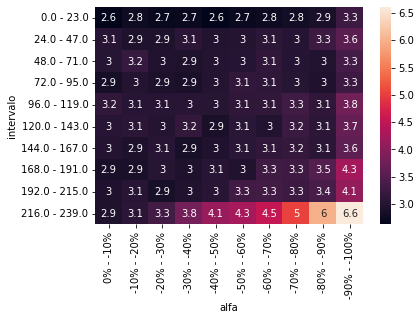

In [ ]:
import seaborn as sns

iPos = []

for y in range(10):
  iPos.append(str((PH / 10) * y) + " - " + str(((PH / 10) * (y + 1)) - 1))

iAlf = []
if (signo == "+"):
  iAlf = ['0% - 10%', '10% - 20%', '20% - 30%', '30% - 40%', '40% - 50%', '50% - 60%', '60% - 70%', '70% - 80%', '80% - 90%', '90% - 100%']
else:
  iAlf = ['0% - -10%', '-10% - -20%', '-20% - -30%', '-30% - -40%', '-40% - -50%', '-50% - -60%', '-60% - -70%', '-70% - -80%', '-80% - -90%', '-90% - -100%']

np.random.seed(0)
data = {
    'intervalo': np.tile(iPos, 10),
    'alfa': np.repeat(iAlf, 10),
    'variación': errors
  }

df = pd.DataFrame(data, columns = ['intervalo', 'alfa', 'variación'])
df = df.pivot('intervalo', 'alfa', 'variación')
df = df.reindex(index=iPos)
df = df.reindex(columns=iAlf)

#fig, ax = plt.subplots(figsize=(15,5)) 
#sns.heatmap(df, annot=True, fmt='g', ax=ax)

sns.heatmap(df, annot=True)

### Mapa de calor por intervalos - alfas mixtos

In [ ]:
heat1 = []

for x in range(20):
  heat1.append([])
  for y in range(10):
    heat1[x].append([])

for ij in range(iterations):
  if (results['FACTOR'][ij] <= -0.9 and results['FACTOR'][ij] >= -1):
    if (results['DATO'][ij] >= 0 and results['DATO'][ij] < (PH / 10)):
      heat1[0][0].append(results['MAE'][ij])
    if (results['DATO'][ij] >= (PH / 10) and results['DATO'][ij] < ((PH / 10)*2)):
      heat1[0][1].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*2) and results['DATO'][ij] < ((PH / 10)*3)):
      heat1[0][2].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*3) and results['DATO'][ij] < ((PH / 10)*4)):
      heat1[0][3].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*4) and results['DATO'][ij] < ((PH / 10)*5)):
      heat1[0][4].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*5) and results['DATO'][ij] < ((PH / 10)*6)):
      heat1[0][5].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*6) and results['DATO'][ij] < ((PH / 10)*7)):
      heat1[0][6].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*7) and results['DATO'][ij] < ((PH / 10)*8)):
      heat1[0][7].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*8) and results['DATO'][ij] < ((PH / 10)*9)):
      heat1[0][8].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*9) and results['DATO'][ij] <= ((PH / 10)*10)):
      heat1[0][9].append(results['MAE'][ij])
  if (results['FACTOR'][ij] <= -0.8 and results['FACTOR'][ij] > -0.9):
    if (results['DATO'][ij] >= 0 and results['DATO'][ij] < (PH / 10)):
      heat1[1][0].append(results['MAE'][ij])
    if (results['DATO'][ij] >= (PH / 10) and results['DATO'][ij] < ((PH / 10)*2)):
      heat1[1][1].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*2) and results['DATO'][ij] < ((PH / 10)*3)):
      heat1[1][2].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*3) and results['DATO'][ij] < ((PH / 10)*4)):
      heat1[1][3].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*4) and results['DATO'][ij] < ((PH / 10)*5)):
      heat1[1][4].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*5) and results['DATO'][ij] < ((PH / 10)*6)):
      heat1[1][5].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*6) and results['DATO'][ij] < ((PH / 10)*7)):
      heat1[1][6].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*7) and results['DATO'][ij] < ((PH / 10)*8)):
      heat1[1][7].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*8) and results['DATO'][ij] < ((PH / 10)*9)):
      heat1[1][8].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*9) and results['DATO'][ij] <= ((PH / 10)*10)):
      heat1[1][9].append(results['MAE'][ij])
  if (results['FACTOR'][ij] <= -0.7 and results['FACTOR'][ij] > -0.8):
    if (results['DATO'][ij] >= 0 and results['DATO'][ij] < (PH / 10)):
      heat1[2][0].append(results['MAE'][ij])
    if (results['DATO'][ij] >= (PH / 10) and results['DATO'][ij] < ((PH / 10)*2)):
      heat1[2][1].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*2) and results['DATO'][ij] < ((PH / 10)*3)):
      heat1[2][2].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*3) and results['DATO'][ij] < ((PH / 10)*4)):
      heat1[2][3].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*4) and results['DATO'][ij] < ((PH / 10)*5)):
      heat1[2][4].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*5) and results['DATO'][ij] < ((PH / 10)*6)):
      heat1[2][5].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*6) and results['DATO'][ij] < ((PH / 10)*7)):
      heat1[2][6].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*7) and results['DATO'][ij] < ((PH / 10)*8)):
      heat1[2][7].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*8) and results['DATO'][ij] < ((PH / 10)*9)):
      heat1[2][8].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*9) and results['DATO'][ij] <= ((PH / 10)*10)):
      heat1[2][9].append(results['MAE'][ij])
  if (results['FACTOR'][ij] <= -0.6 and results['FACTOR'][ij] > -0.7):
    if (results['DATO'][ij] >= 0 and results['DATO'][ij] < (PH / 10)):
      heat1[3][0].append(results['MAE'][ij])
    if (results['DATO'][ij] >= (PH / 10) and results['DATO'][ij] < ((PH / 10)*2)):
      heat1[3][1].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*2) and results['DATO'][ij] < ((PH / 10)*3)):
      heat1[3][2].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*3) and results['DATO'][ij] < ((PH / 10)*4)):
      heat1[3][3].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*4) and results['DATO'][ij] < ((PH / 10)*5)):
      heat1[3][4].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*5) and results['DATO'][ij] < ((PH / 10)*6)):
      heat1[3][5].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*6) and results['DATO'][ij] < ((PH / 10)*7)):
      heat1[3][6].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*7) and results['DATO'][ij] < ((PH / 10)*8)):
      heat1[3][7].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*8) and results['DATO'][ij] < ((PH / 10)*9)):
      heat1[3][8].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*9) and results['DATO'][ij] <= ((PH / 10)*10)):
      heat1[3][9].append(results['MAE'][ij])
  if (results['FACTOR'][ij] <= -0.5 and results['FACTOR'][ij] > -0.6):
    if (results['DATO'][ij] >= 0 and results['DATO'][ij] < (PH / 10)):
      heat1[4][0].append(results['MAE'][ij])
    if (results['DATO'][ij] >= (PH / 10) and results['DATO'][ij] < ((PH / 10)*2)):
      heat1[4][1].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*2) and results['DATO'][ij] < ((PH / 10)*3)):
      heat1[4][2].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*3) and results['DATO'][ij] < ((PH / 10)*4)):
      heat1[4][3].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*4) and results['DATO'][ij] < ((PH / 10)*5)):
      heat1[4][4].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*5) and results['DATO'][ij] < ((PH / 10)*6)):
      heat1[4][5].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*6) and results['DATO'][ij] < ((PH / 10)*7)):
      heat1[4][6].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*7) and results['DATO'][ij] < ((PH / 10)*8)):
      heat1[4][7].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*8) and results['DATO'][ij] < ((PH / 10)*9)):
      heat1[4][8].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*9) and results['DATO'][ij] <= ((PH / 10)*10)):
      heat1[4][9].append(results['MAE'][ij])
  if (results['FACTOR'][ij] <= -0.4 and results['FACTOR'][ij] > -0.5):
    if (results['DATO'][ij] >= 0 and results['DATO'][ij] < (PH / 10)):
      heat1[5][0].append(results['MAE'][ij])
    if (results['DATO'][ij] >= (PH / 10) and results['DATO'][ij] < ((PH / 10)*2)):
      heat1[5][1].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*2) and results['DATO'][ij] < ((PH / 10)*3)):
      heat1[5][2].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*3) and results['DATO'][ij] < ((PH / 10)*4)):
      heat1[5][3].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*4) and results['DATO'][ij] < ((PH / 10)*5)):
      heat1[5][4].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*5) and results['DATO'][ij] < ((PH / 10)*6)):
      heat1[5][5].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*6) and results['DATO'][ij] < ((PH / 10)*7)):
      heat1[5][6].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*7) and results['DATO'][ij] < ((PH / 10)*8)):
      heat1[5][7].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*8) and results['DATO'][ij] < ((PH / 10)*9)):
      heat1[5][8].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*9) and results['DATO'][ij] <= ((PH / 10)*10)):
      heat1[5][9].append(results['MAE'][ij])
  if (results['FACTOR'][ij] <= -0.3 and results['FACTOR'][ij] > -0.4):
    if (results['DATO'][ij] >= 0 and results['DATO'][ij] < (PH / 10)):
      heat1[6][0].append(results['MAE'][ij])
    if (results['DATO'][ij] >= (PH / 10) and results['DATO'][ij] < ((PH / 10)*2)):
      heat1[6][1].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*2) and results['DATO'][ij] < ((PH / 10)*3)):
      heat1[6][2].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*3) and results['DATO'][ij] < ((PH / 10)*4)):
      heat1[6][3].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*4) and results['DATO'][ij] < ((PH / 10)*5)):
      heat1[6][4].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*5) and results['DATO'][ij] < ((PH / 10)*6)):
      heat1[6][5].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*6) and results['DATO'][ij] < ((PH / 10)*7)):
      heat1[6][6].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*7) and results['DATO'][ij] < ((PH / 10)*8)):
      heat1[6][7].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*8) and results['DATO'][ij] < ((PH / 10)*9)):
      heat1[6][8].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*9) and results['DATO'][ij] <= ((PH / 10)*10)):
      heat1[6][9].append(results['MAE'][ij])
  if (results['FACTOR'][ij] <= -0.2 and results['FACTOR'][ij] > -0.3):
    if (results['DATO'][ij] >= 0 and results['DATO'][ij] < (PH / 10)):
      heat1[7][0].append(results['MAE'][ij])
    if (results['DATO'][ij] >= (PH / 10) and results['DATO'][ij] < ((PH / 10)*2)):
      heat1[7][1].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*2) and results['DATO'][ij] < ((PH / 10)*3)):
      heat1[7][2].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*3) and results['DATO'][ij] < ((PH / 10)*4)):
      heat1[7][3].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*4) and results['DATO'][ij] < ((PH / 10)*5)):
      heat1[7][4].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*5) and results['DATO'][ij] < ((PH / 10)*6)):
      heat1[7][5].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*6) and results['DATO'][ij] < ((PH / 10)*7)):
      heat1[7][6].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*7) and results['DATO'][ij] < ((PH / 10)*8)):
      heat1[7][7].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*8) and results['DATO'][ij] < ((PH / 10)*9)):
      heat1[7][8].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*9) and results['DATO'][ij] <= ((PH / 10)*10)):
      heat1[7][9].append(results['MAE'][ij])
  if (results['FACTOR'][ij] <= -0.1 and results['FACTOR'][ij] > -0.2):
    if (results['DATO'][ij] >= 0 and results['DATO'][ij] < (PH / 10)):
      heat1[8][0].append(results['MAE'][ij])
    if (results['DATO'][ij] >= (PH / 10) and results['DATO'][ij] < ((PH / 10)*2)):
      heat1[8][1].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*2) and results['DATO'][ij] < ((PH / 10)*3)):
      heat1[8][2].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*3) and results['DATO'][ij] < ((PH / 10)*4)):
      heat1[8][3].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*4) and results['DATO'][ij] < ((PH / 10)*5)):
      heat1[8][4].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*5) and results['DATO'][ij] < ((PH / 10)*6)):
      heat1[8][5].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*6) and results['DATO'][ij] < ((PH / 10)*7)):
      heat1[8][6].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*7) and results['DATO'][ij] < ((PH / 10)*8)):
      heat1[8][7].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*8) and results['DATO'][ij] < ((PH / 10)*9)):
      heat1[8][8].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*9) and results['DATO'][ij] <= ((PH / 10)*10)):
      heat1[8][9].append(results['MAE'][ij])
  if (results['FACTOR'][ij] <= 0. and results['FACTOR'][ij] >= -0.1):
    if (results['DATO'][ij] >= 0 and results['DATO'][ij] < (PH / 10)):
      heat1[9][0].append(results['MAE'][ij])
    if (results['DATO'][ij] >= (PH / 10) and results['DATO'][ij] < ((PH / 10)*2)):
      heat1[9][1].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*2) and results['DATO'][ij] < ((PH / 10)*3)):
      heat1[9][2].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*3) and results['DATO'][ij] < ((PH / 10)*4)):
      heat1[9][3].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*4) and results['DATO'][ij] < ((PH / 10)*5)):
      heat1[9][4].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*5) and results['DATO'][ij] < ((PH / 10)*6)):
      heat1[9][5].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*6) and results['DATO'][ij] < ((PH / 10)*7)):
      heat1[9][6].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*7) and results['DATO'][ij] < ((PH / 10)*8)):
      heat1[9][7].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*8) and results['DATO'][ij] < ((PH / 10)*9)):
      heat1[9][8].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*9) and results['DATO'][ij] <= ((PH / 10)*10)):
      heat1[9][9].append(results['MAE'][ij])
  if (results['FACTOR'][ij] >= 0. and results['FACTOR'][ij] < 0.1):
    if (results['DATO'][ij] >= 0 and results['DATO'][ij] < (PH / 10)):
      heat1[10][0].append(results['MAE'][ij])
    if (results['DATO'][ij] >= (PH / 10) and results['DATO'][ij] < ((PH / 10)*2)):
      heat1[10][1].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*2) and results['DATO'][ij] < ((PH / 10)*3)):
      heat1[10][2].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*3) and results['DATO'][ij] < ((PH / 10)*4)):
      heat1[10][3].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*4) and results['DATO'][ij] < ((PH / 10)*5)):
      heat1[10][4].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*5) and results['DATO'][ij] < ((PH / 10)*6)):
      heat1[10][5].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*6) and results['DATO'][ij] < ((PH / 10)*7)):
      heat1[10][6].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*7) and results['DATO'][ij] < ((PH / 10)*8)):
      heat1[10][7].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*8) and results['DATO'][ij] < ((PH / 10)*9)):
      heat1[10][8].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*9) and results['DATO'][ij] <= ((PH / 10)*10)):
      heat1[10][9].append(results['MAE'][ij])
  if (results['FACTOR'][ij] >= 0.1 and results['FACTOR'][ij] < 0.2):
    if (results['DATO'][ij] >= 0 and results['DATO'][ij] < (PH / 10)):
      heat1[11][0].append(results['MAE'][ij])
    if (results['DATO'][ij] >= (PH / 10) and results['DATO'][ij] < ((PH / 10)*2)):
      heat1[11][1].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*2) and results['DATO'][ij] < ((PH / 10)*3)):
      heat1[11][2].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*3) and results['DATO'][ij] < ((PH / 10)*4)):
      heat1[11][3].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*4) and results['DATO'][ij] < ((PH / 10)*5)):
      heat1[11][4].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*5) and results['DATO'][ij] < ((PH / 10)*6)):
      heat1[11][5].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*6) and results['DATO'][ij] < ((PH / 10)*7)):
      heat1[11][6].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*7) and results['DATO'][ij] < ((PH / 10)*8)):
      heat1[11][7].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*8) and results['DATO'][ij] < ((PH / 10)*9)):
      heat1[11][8].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*9) and results['DATO'][ij] <= ((PH / 10)*10)):
      heat1[11][9].append(results['MAE'][ij])
  if (results['FACTOR'][ij] >= 0.2 and results['FACTOR'][ij] < 0.3):
    if (results['DATO'][ij] >= 0 and results['DATO'][ij] < (PH / 10)):
      heat1[12][0].append(results['MAE'][ij])
    if (results['DATO'][ij] >= (PH / 10) and results['DATO'][ij] < ((PH / 10)*2)):
      heat1[12][1].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*2) and results['DATO'][ij] < ((PH / 10)*3)):
      heat1[12][2].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*3) and results['DATO'][ij] < ((PH / 10)*4)):
      heat1[12][3].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*4) and results['DATO'][ij] < ((PH / 10)*5)):
      heat1[12][4].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*5) and results['DATO'][ij] < ((PH / 10)*6)):
      heat1[12][5].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*6) and results['DATO'][ij] < ((PH / 10)*7)):
      heat1[12][6].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*7) and results['DATO'][ij] < ((PH / 10)*8)):
      heat1[12][7].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*8) and results['DATO'][ij] < ((PH / 10)*9)):
      heat1[12][8].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*9) and results['DATO'][ij] <= ((PH / 10)*10)):
      heat1[12][9].append(results['MAE'][ij])
  if (results['FACTOR'][ij] >= 0.3 and results['FACTOR'][ij] < 0.4):
    if (results['DATO'][ij] >= 0 and results['DATO'][ij] < (PH / 10)):
      heat1[13][0].append(results['MAE'][ij])
    if (results['DATO'][ij] >= (PH / 10) and results['DATO'][ij] < ((PH / 10)*2)):
      heat1[13][1].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*2) and results['DATO'][ij] < ((PH / 10)*3)):
      heat1[13][2].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*3) and results['DATO'][ij] < ((PH / 10)*4)):
      heat1[13][3].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*4) and results['DATO'][ij] < ((PH / 10)*5)):
      heat1[13][4].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*5) and results['DATO'][ij] < ((PH / 10)*6)):
      heat1[13][5].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*6) and results['DATO'][ij] < ((PH / 10)*7)):
      heat1[13][6].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*7) and results['DATO'][ij] < ((PH / 10)*8)):
      heat1[13][7].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*8) and results['DATO'][ij] < ((PH / 10)*9)):
      heat1[13][8].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*9) and results['DATO'][ij] <= ((PH / 10)*10)):
      heat1[13][9].append(results['MAE'][ij])
  if (results['FACTOR'][ij] >= 0.4 and results['FACTOR'][ij] < 0.5):
    if (results['DATO'][ij] >= 0 and results['DATO'][ij] < (PH / 10)):
      heat1[14][0].append(results['MAE'][ij])
    if (results['DATO'][ij] >= (PH / 10) and results['DATO'][ij] < ((PH / 10)*2)):
      heat1[14][1].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*2) and results['DATO'][ij] < ((PH / 10)*3)):
      heat1[14][2].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*3) and results['DATO'][ij] < ((PH / 10)*4)):
      heat1[14][3].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*4) and results['DATO'][ij] < ((PH / 10)*5)):
      heat1[14][4].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*5) and results['DATO'][ij] < ((PH / 10)*6)):
      heat1[14][5].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*6) and results['DATO'][ij] < ((PH / 10)*7)):
      heat1[14][6].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*7) and results['DATO'][ij] < ((PH / 10)*8)):
      heat1[14][7].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*8) and results['DATO'][ij] < ((PH / 10)*9)):
      heat1[14][8].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*9) and results['DATO'][ij] <= ((PH / 10)*10)):
      heat1[14][9].append(results['MAE'][ij])
  if (results['FACTOR'][ij] >= 0.5 and results['FACTOR'][ij] < 0.6):
    if (results['DATO'][ij] >= 0 and results['DATO'][ij] < (PH / 10)):
      heat1[15][0].append(results['MAE'][ij])
    if (results['DATO'][ij] >= (PH / 10) and results['DATO'][ij] < ((PH / 10)*2)):
      heat1[15][1].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*2) and results['DATO'][ij] < ((PH / 10)*3)):
      heat1[15][2].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*3) and results['DATO'][ij] < ((PH / 10)*4)):
      heat1[15][3].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*4) and results['DATO'][ij] < ((PH / 10)*5)):
      heat1[15][4].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*5) and results['DATO'][ij] < ((PH / 10)*6)):
      heat1[15][5].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*6) and results['DATO'][ij] < ((PH / 10)*7)):
      heat1[15][6].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*7) and results['DATO'][ij] < ((PH / 10)*8)):
      heat1[15][7].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*8) and results['DATO'][ij] < ((PH / 10)*9)):
      heat1[15][8].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*9) and results['DATO'][ij] <= ((PH / 10)*10)):
      heat1[15][9].append(results['MAE'][ij])
  if (results['FACTOR'][ij] >= 0.6 and results['FACTOR'][ij] < 0.7):
    if (results['DATO'][ij] >= 0 and results['DATO'][ij] < (PH / 10)):
      heat1[16][0].append(results['MAE'][ij])
    if (results['DATO'][ij] >= (PH / 10) and results['DATO'][ij] < ((PH / 10)*2)):
      heat1[16][1].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*2) and results['DATO'][ij] < ((PH / 10)*3)):
      heat1[16][2].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*3) and results['DATO'][ij] < ((PH / 10)*4)):
      heat1[16][3].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*4) and results['DATO'][ij] < ((PH / 10)*5)):
      heat1[16][4].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*5) and results['DATO'][ij] < ((PH / 10)*6)):
      heat1[16][5].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*6) and results['DATO'][ij] < ((PH / 10)*7)):
      heat1[16][6].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*7) and results['DATO'][ij] < ((PH / 10)*8)):
      heat1[16][7].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*8) and results['DATO'][ij] < ((PH / 10)*9)):
      heat1[16][8].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*9) and results['DATO'][ij] <= ((PH / 10)*10)):
      heat1[16][9].append(results['MAE'][ij])
  if (results['FACTOR'][ij] >= 0.7 and results['FACTOR'][ij] < 0.8):
    if (results['DATO'][ij] >= 0 and results['DATO'][ij] < (PH / 10)):
      heat1[17][0].append(results['MAE'][ij])
    if (results['DATO'][ij] >= (PH / 10) and results['DATO'][ij] < ((PH / 10)*2)):
      heat1[17][1].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*2) and results['DATO'][ij] < ((PH / 10)*3)):
      heat1[17][2].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*3) and results['DATO'][ij] < ((PH / 10)*4)):
      heat1[17][3].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*4) and results['DATO'][ij] < ((PH / 10)*5)):
      heat1[17][4].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*5) and results['DATO'][ij] < ((PH / 10)*6)):
      heat1[17][5].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*6) and results['DATO'][ij] < ((PH / 10)*7)):
      heat1[17][6].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*7) and results['DATO'][ij] < ((PH / 10)*8)):
      heat1[17][7].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*8) and results['DATO'][ij] < ((PH / 10)*9)):
      heat1[17][8].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*9) and results['DATO'][ij] <= ((PH / 10)*10)):
      heat1[17][9].append(results['MAE'][ij])
  if (results['FACTOR'][ij] >= 0.8 and results['FACTOR'][ij] < 0.9):
    if (results['DATO'][ij] >= 0 and results['DATO'][ij] < (PH / 10)):
      heat1[18][0].append(results['MAE'][ij])
    if (results['DATO'][ij] >= (PH / 10) and results['DATO'][ij] < ((PH / 10)*2)):
      heat1[18][1].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*2) and results['DATO'][ij] < ((PH / 10)*3)):
      heat1[18][2].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*3) and results['DATO'][ij] < ((PH / 10)*4)):
      heat1[18][3].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*4) and results['DATO'][ij] < ((PH / 10)*5)):
      heat1[18][4].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*5) and results['DATO'][ij] < ((PH / 10)*6)):
      heat1[18][5].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*6) and results['DATO'][ij] < ((PH / 10)*7)):
      heat1[18][6].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*7) and results['DATO'][ij] < ((PH / 10)*8)):
      heat1[18][7].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*8) and results['DATO'][ij] < ((PH / 10)*9)):
      heat1[18][8].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*9) and results['DATO'][ij] <= ((PH / 10)*10)):
      heat1[18][9].append(results['MAE'][ij])
  if (results['FACTOR'][ij] >= 0.9 and results['FACTOR'][ij] <= 1):
    if (results['DATO'][ij] >= 0 and results['DATO'][ij] < (PH / 10)):
      heat1[19][0].append(results['MAE'][ij])
    if (results['DATO'][ij] >= (PH / 10) and results['DATO'][ij] < ((PH / 10)*2)):
      heat1[19][1].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*2) and results['DATO'][ij] < ((PH / 10)*3)):
      heat1[19][2].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*3) and results['DATO'][ij] < ((PH / 10)*4)):
      heat1[19][3].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*4) and results['DATO'][ij] < ((PH / 10)*5)):
      heat1[19][4].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*5) and results['DATO'][ij] < ((PH / 10)*6)):
      heat1[19][5].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*6) and results['DATO'][ij] < ((PH / 10)*7)):
      heat1[19][6].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*7) and results['DATO'][ij] < ((PH / 10)*8)):
      heat1[19][7].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*8) and results['DATO'][ij] < ((PH / 10)*9)):
      heat1[19][8].append(results['MAE'][ij])
    if (results['DATO'][ij] >= ((PH / 10)*9) and results['DATO'][ij] <= ((PH / 10)*10)):
      heat1[19][9].append(results['MAE'][ij])

errors = []

for sublist in heat1:
  error = 0
  for maes in sublist:
    for mae in maes:
      error += mae
    error = error / len(sublist)
    errors.append(error)

print(errors)

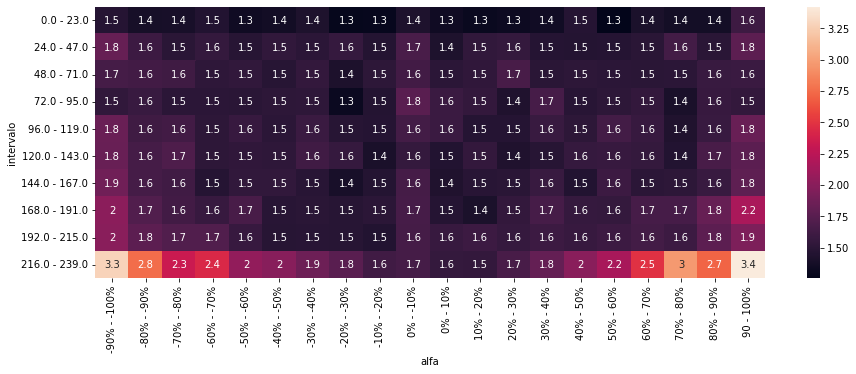

In [ ]:
import seaborn as sns

iPos = []

for y in range(10):
  iPos.append(str((PH / 10) * y) + " - " + str(((PH / 10) * (y + 1)) - 1))

iAlf = ['-90% - -100%', '-80% - -90%', '-70% - -80%', '-60% - -70%', '-50% - -60%', '-40% - -50%', '-30% - -40%', '-20% - -30%', '-10% - -20%', '0% - -10%', '0% - 10%', '10% - 20%', '20% - 30%', '30% - 40%', '40% - 50%', '50% - 60%', '60% - 70%', '70% - 80%', '80% - 90%', '90 - 100%']

np.random.seed(0)
data = {
    'intervalo': np.tile(iPos, 20),
    'alfa': np.repeat(iAlf, 10),
    'variación': errors
  }

df = pd.DataFrame(data, columns = ['intervalo', 'alfa', 'variación'])
df = df.pivot('intervalo', 'alfa', 'variación')
df = df.reindex(index=iPos)
df = df.reindex(columns=iAlf)

fig, ax = plt.subplots(figsize=(15,5)) 
sns.heatmap(df, annot=True, ax=ax)

### Generador de Reglas

In [ ]:
#store_data = pd.read_csv(rules, header=None)
#store_data.head()

rules = []

# Read training set
filename = '/content/drive/MyDrive/Investigación/CSVs Experimentos estudio de lags/Experimento 24/Experimento24Pendiente.csv'
datos = pd.read_csv(filename, sep=',')
#datos = datos.set_index('posicion')

for ij in range(len(datos)):
  rules.append([datos['posicion'][ij], datos['pendiente'][ij]])

PH = 240 # 240
FH = 24 # 24

iterations = len(datos)

association_rules = apriori(rules, min_support=0.009, min_confidence=0.2, min_lift=3, min_length=2)

for item in association_rules:
  # first index of the inner list
  # Contains base item and add item
  pair = item[0] 
  items = [x for x in pair]
  print("Rule: " + str(items[0]) + " -> " + str(items[1]))

  #second index of the inner list
  print("Support: " + str(item[1]))

  #third index of the list located at 0th
  #of the third index of the inner list

  print("Confidence: " + str(item[2][0][2]))
  print("Lift: " + str(item[2][0][3]))
  print("=====================================")

# Registro en CSV

In [ ]:
import csv

with open('/content/drive/MyDrive/Investigación/CSVs Paper/Experimento12.csv', 'w') as csvfile:
  fieldnames = ['id', 'posicion', 'alfa', 'variacion']
  writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

  writer.writeheader()
  for ij in range(iterations):
    writer.writerow({'id': ij,
                     'posicion': results['DATO'][ij],
                     'alfa': results['FACTOR'][ij],
                     'variacion': results['MAE'][ij]})

# Lectura de CSV

In [ ]:
from collections import defaultdict
results = defaultdict(lambda: {})

# Read training set
filename = '/content/drive/MyDrive/Investigación/CSVs Paper/Experimento14.csv'
datos = pd.read_csv(filename, sep=',')
datos = datos.set_index('id')

for ij in range(len(datos)):
  results['DATO'][ij] = datos['posicion'][ij]
  results['FACTOR'][ij] = datos['alfa'][ij]
  results['MAE'][ij] = datos['variacion'][ij]

PH = 365 # 240
FH = 2 # 24

iterations = len(datos)

# Obtención de parámetros

In [ ]:
for x in np.arange(0.05,0.1,0.0050):
  variacion = x
  alfas = []
  intervalos = []
  maes = []
  for ij in range(iterations):
    #if ((results['MAE'][ij] - results['MAE'][0]) >= variacion):
    if ((results['MAE'][ij] - results['MAE'][0]) >= variacion and (results['MAE'][ij] - results['MAE'][0]) <= (variacion + 0.005)):
      maes.append(results['MAE'][ij])
      alfas.append(results['FACTOR'][ij])
      intervalos.append(results['DATO'][ij])

  print('Para una variación del MAE de más de {0} '.format(variacion))
  print('La media de los MAEs obtenidos es', np.mean(maes))
  print('La media de los alfas aplicados es', np.mean(alfas))
  print('El alfa más pequeño aplicado es', min(alfas))
  print('El alfa más grande aplicado es', max(alfas))
  print('La media de las posiciones afectadas es', np.mean(intervalos))
  print('La posicion más alejada del horizonte de predicción afectada es', min(intervalos))
  print('La posicion más cercana del horizonte de predicción afectada es', max(intervalos))
  print('- - - - - - - - - - -')

### Ranking de MAEs

In [ ]:
import operator

items = 9999

for ij in range(items):
  top = max(results['MAE'].items(), key=operator.itemgetter(1))
  id = top[0]
  mae = top[1]
  pos = results['DATO'][id]
  alfa = results['FACTOR'][id]

  if (pos <= 190 and mae >= 0.05) :
    print('El máximo MAE es {0}, modificando la posición {1} en un {2}%'.format(mae, pos, alfa * 100))

  results['MAE'].pop(id)
  results['DATO'].pop(id)
  results['FACTOR'].pop(id)

### Ranking de MAES por cuadrantes

In [ ]:
import operator

posI = []
alfI = []

for x in range(10):
  x = x / 10
  for y in range(10):

    array = []

    for ij in range(iterations):
      if (abs(results['FACTOR'][ij]) >= x and abs(results['FACTOR'][ij]) < (x + 0.1)):
        if (results['DATO'][ij] >= ((PH / 10) * y) and results['DATO'][ij] < ((PH / 10) * (y + 1))):
          array.append((ij, results['MAE'][ij]))

    error = 0 
    for mae in array:
      error += mae[1]
    error = error / len(array)

    #print('Cuadrante comprendido entre las posiciones {0} y {1}, siendo PH {2}, y entre los alfas {3} y {4}'.format((PH / 10) * y, (PH / 10) * (y + 1), PH, x, x + 0.1))
    #print('La media de MAEs es {0}'.format(error))
    maxT = max(array, key=operator.itemgetter(1))
    #print('El MAE es {0}, modificando la posición {1} en un {2}%'.format(maxT[1], results['DATO'][maxT[0]], results['FACTOR'][maxT[0]] * 100))
    posI.append(results['DATO'][maxT[0]])
    alfI.append(results['FACTOR'][maxT[0]] * 100)


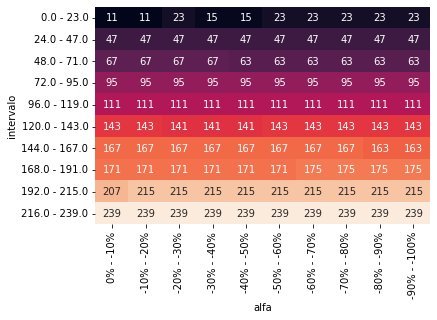

In [ ]:
import seaborn as sns

iPos = []

for y in range(10):
  iPos.append(str((PH / 10) * y) + " - " + str(((PH / 10) * (y + 1)) - 1))

iAlf = []
if (signo == "+"):
  iAlf = ['0% - 10%', '10% - 20%', '20% - 30%', '30% - 40%', '40% - 50%', '50% - 60%', '60% - 70%', '70% - 80%', '80% - 90%', '90% - 100%']
else:
  iAlf = ['0% - -10%', '-10% - -20%', '-20% - -30%', '-30% - -40%', '-40% - -50%', '-50% - -60%', '-60% - -70%', '-70% - -80%', '-80% - -90%', '-90% - -100%']

np.random.seed(0)
data = {
    'intervalo': np.tile(iPos, 10),
    'alfa': np.repeat(iAlf, 10),
    'variación': posI
  }

df = pd.DataFrame(data, columns = ['intervalo', 'alfa', 'variación'])
df = df.pivot('intervalo', 'alfa', 'variación')
df = df.reindex(index=iPos)
df = df.reindex(columns=iAlf)

sns.heatmap(df, annot=True, fmt='g', cbar=False)

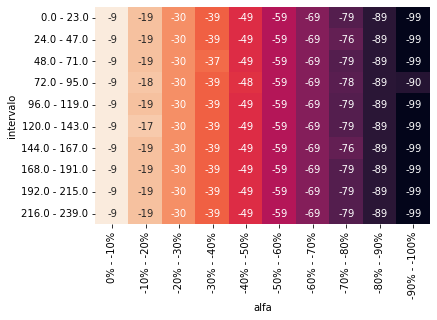

In [ ]:
import seaborn as sns

iPos = []

for y in range(10):
  iPos.append(str((PH / 10) * y) + " - " + str(((PH / 10) * (y + 1)) - 1))

iAlf = []
if (signo == "+"):
  iAlf = ['0% - 10%', '10% - 20%', '20% - 30%', '30% - 40%', '40% - 50%', '50% - 60%', '60% - 70%', '70% - 80%', '80% - 90%', '90% - 100%']
else:
  iAlf = ['0% - -10%', '-10% - -20%', '-20% - -30%', '-30% - -40%', '-40% - -50%', '-50% - -60%', '-60% - -70%', '-70% - -80%', '-80% - -90%', '-90% - -100%']

np.random.seed(0)
data = {
    'intervalo': np.tile(iPos, 10),
    'alfa': np.repeat(iAlf, 10),
    'variación': alfI
  }

df = pd.DataFrame(data, columns = ['intervalo', 'alfa', 'variación'])
df = df.pivot('intervalo', 'alfa', 'variación')
df = df.reindex(index=iPos)
df = df.reindex(columns=iAlf)

sns.heatmap(df, annot=True, cbar=False)

### Mapa de calor atómico - Signo único

In [ ]:
heat2 = []

for x in range(101):
  heat2.append([])
  for y in range(PH):
    heat2[x].append([])

for ij in range(iterations):
  heat2[int(abs(results['FACTOR'][ij]) * 100)][results['DATO'][ij]].append(results['MAE'][ij])

for x in range(101):
  for y in range(PH):
    if (len(heat2[x][y]) == 0):
      heat2[x][y].append(0)
    elif (len(heat2[x][y]) != 1):
      m = 0
      for z in heat2[x][y]:
        m = m + z
      media = m / len(heat2[x][y])
      heat2[x][y] = [media]

errors = []
for x in range(101):
  for y in range(PH):
    for z in heat2[x][y]:
      errors.append(z)


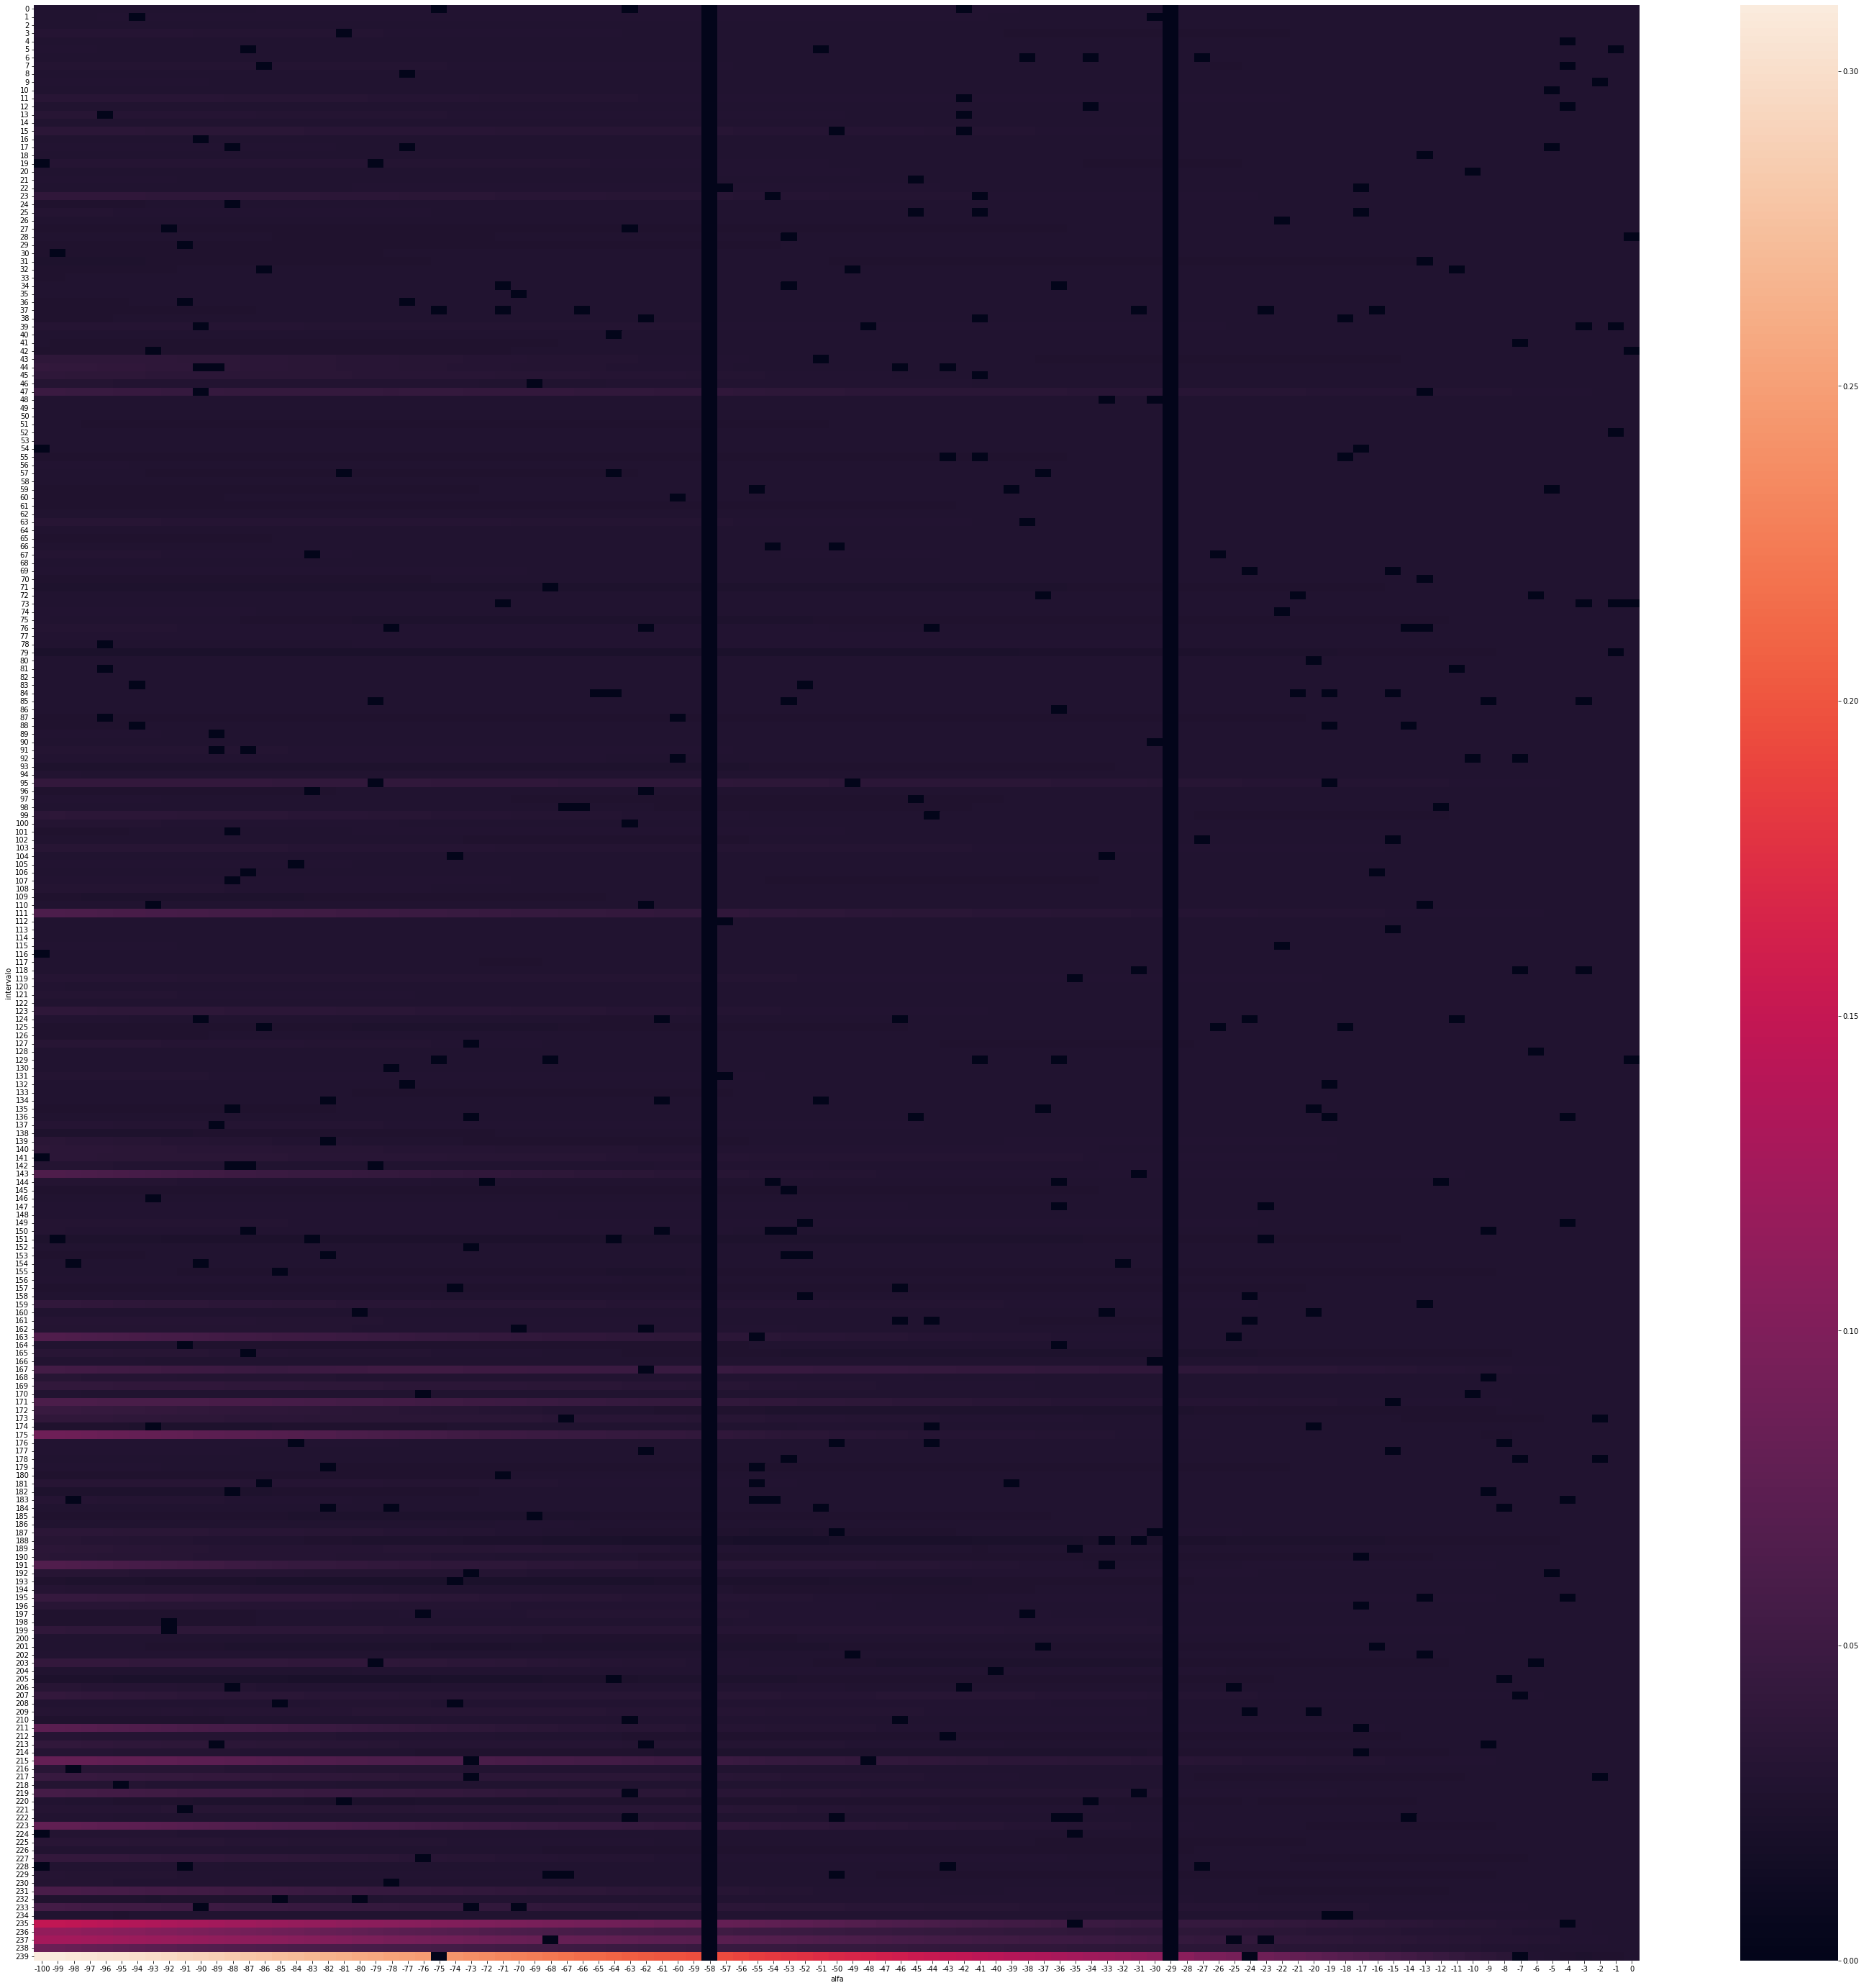

In [ ]:
import seaborn as sns

index_pos = np.arange(0, PH)
index_alfa = np.arange(0, 101)

#index_alfa[::-1] valores negativos

np.random.seed(0)
data = {
    'intervalo': np.tile(index_pos, 101),
    'alfa': np.repeat(index_alfa, PH),
    'variación': errors
  }

df = pd.DataFrame(data, columns = ['intervalo', 'alfa', 'variación'])
df = df.pivot('intervalo', 'alfa', 'variación')

fig, ax = plt.subplots(figsize=(50,50)) 

sns.heatmap(df, ax=ax)

### Mapa de calor atómico - Signo mixto

In [ ]:
heat2 = []

for x in range(201):
  heat2.append([])
  for y in range(PH):
    heat2[x].append([])

for ij in range(iterations):
  if (int(results['FACTOR'][ij] * 100) >= 0):
    num = int(results['FACTOR'][ij] * 100) + 100
  else:
    num = 50 - (int(abs(results['FACTOR'][ij]) * 100) - 50)
  heat2[num][results['DATO'][ij]].append(results['MAE'][ij])

for x in range(201):
  for y in range(PH):
    if (len(heat2[x][y]) == 0):
      heat2[x][y].append(0)
    elif (len(heat2[x][y]) != 1):
      m = 0
      for z in heat2[x][y]:
        m = m + z
      media = m / len(heat2[x][y])
      heat2[x][y] = [media]

errors = []
for x in range(201):
  for y in range(PH):
    for z in heat2[x][y]:
      errors.append(z)

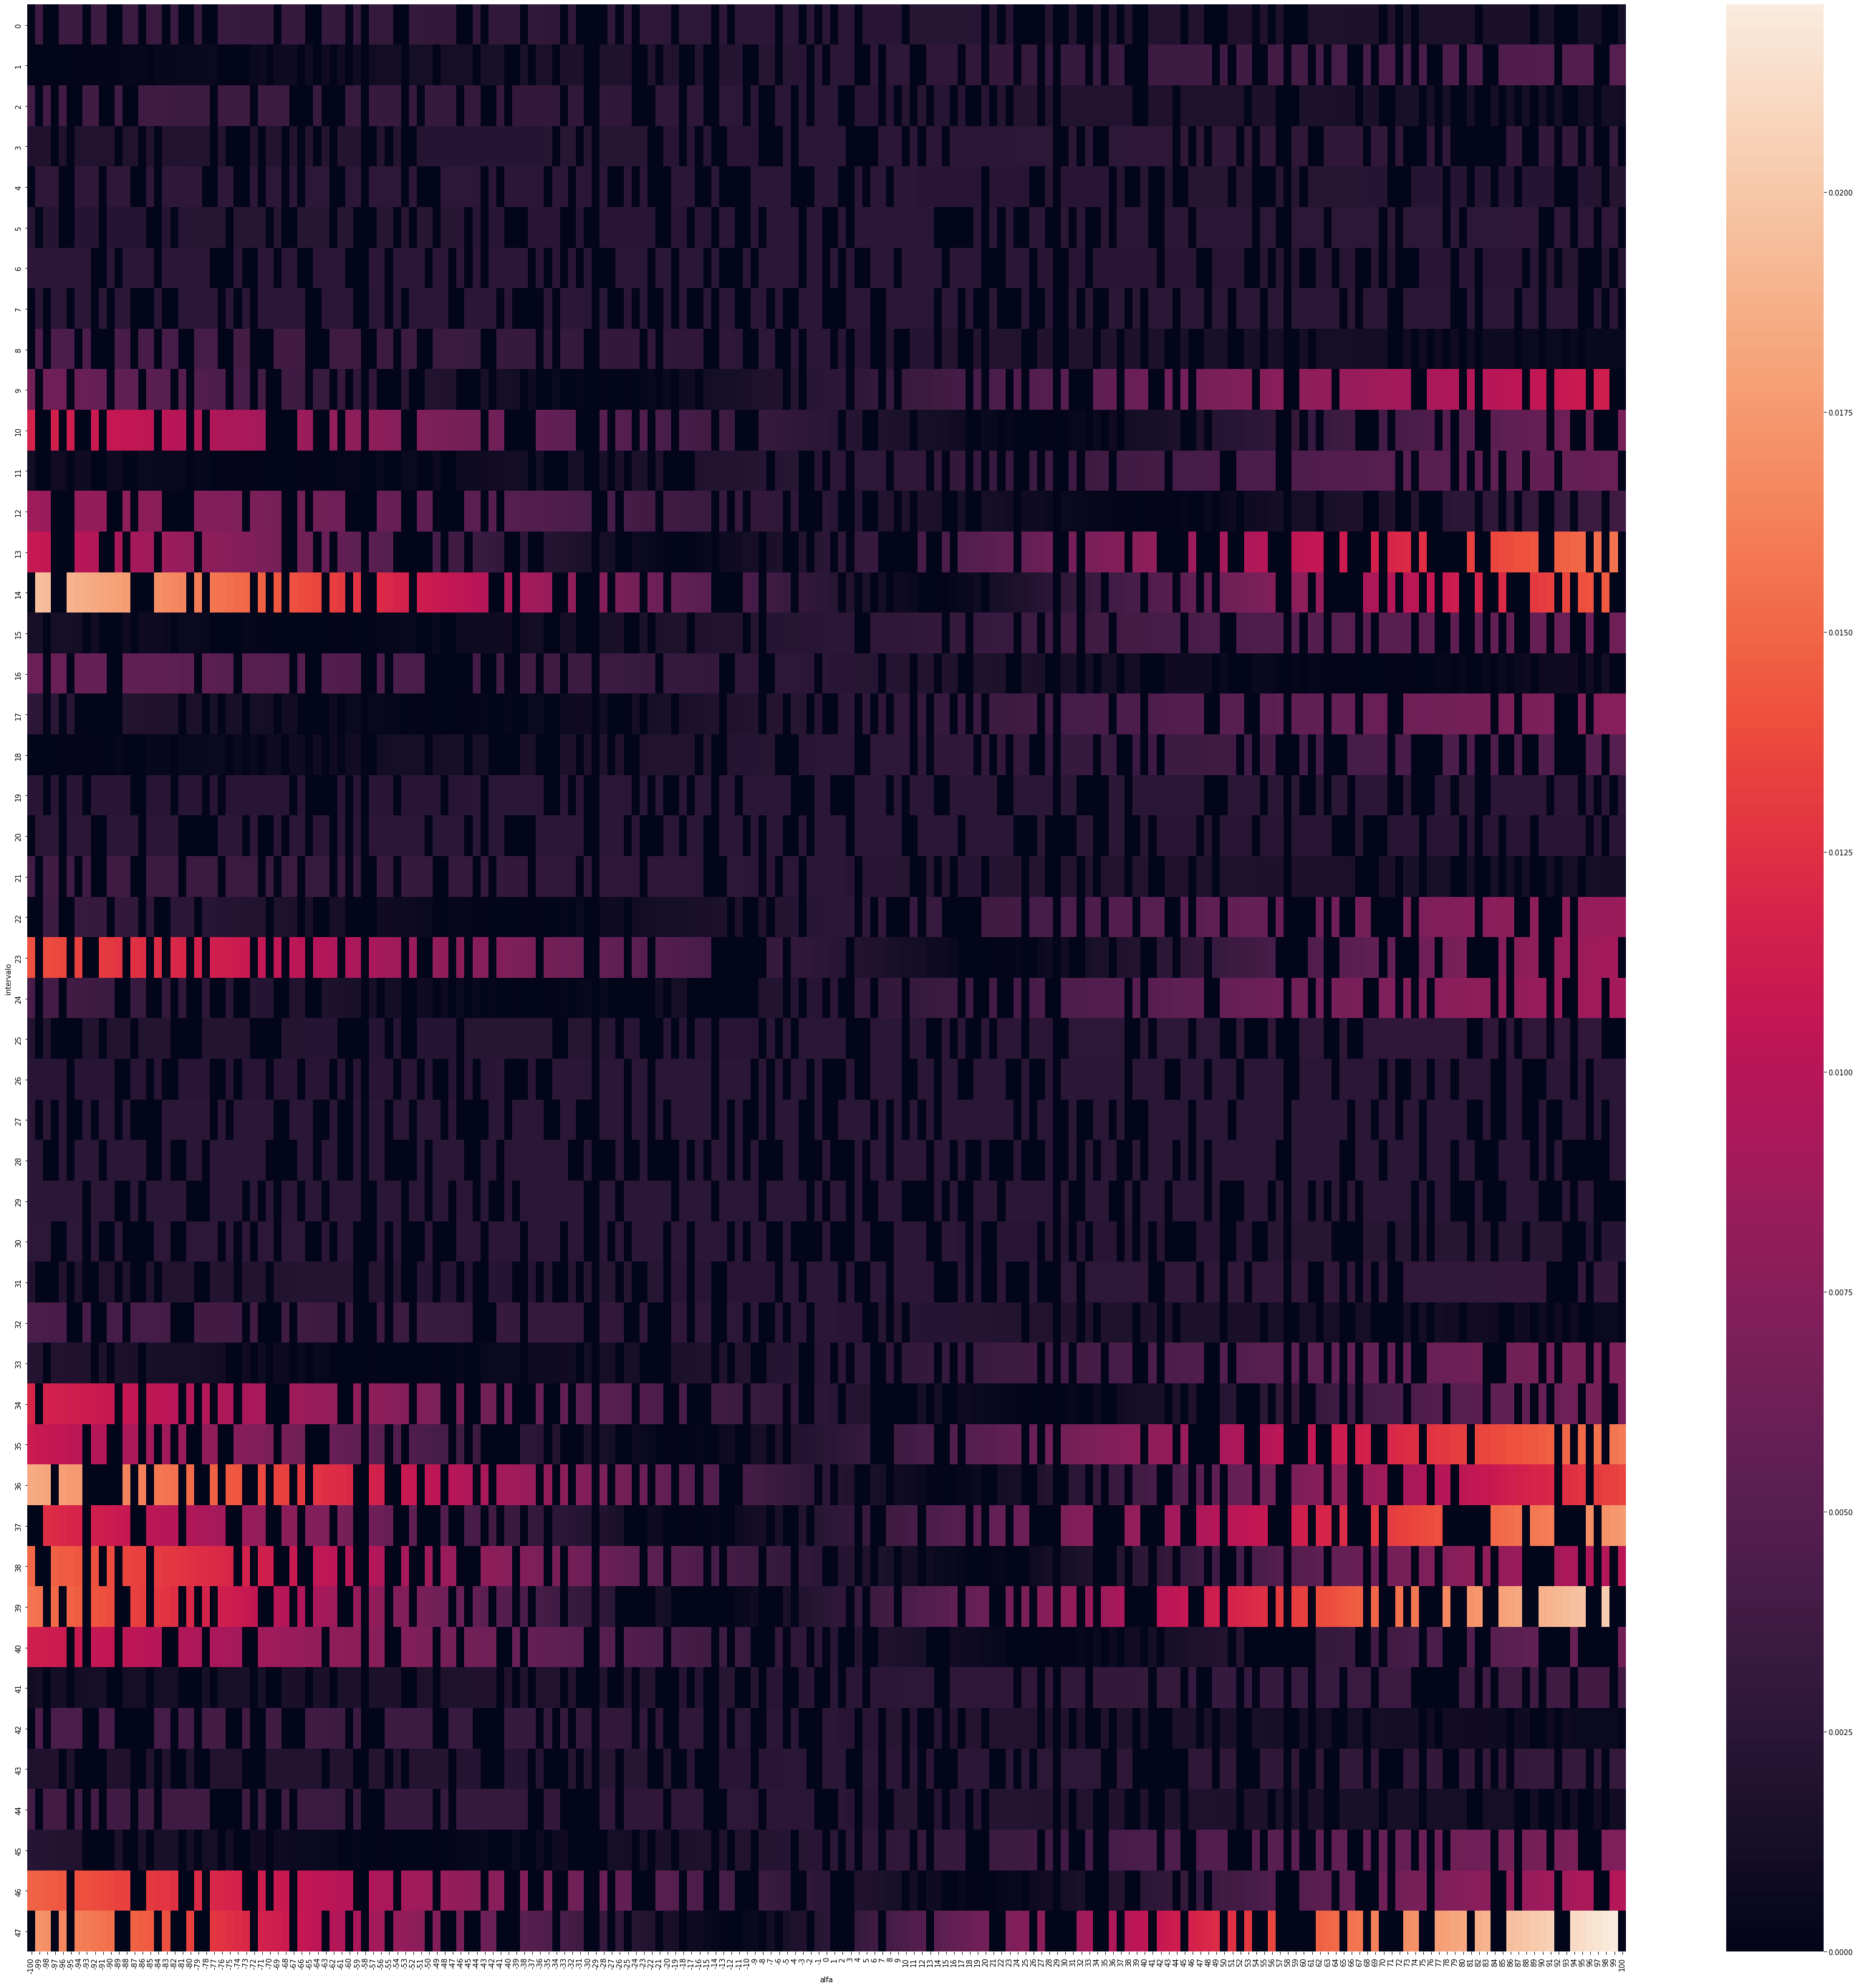

In [ ]:
import seaborn as sns

index_pos = np.arange(0, PH)
index_alfa = np.arange(-100, 101)

np.random.seed(0)
data = {
    'intervalo': np.tile(index_pos, 201),
    'alfa': np.repeat(index_alfa, PH),
    'variación': errors
  }

df = pd.DataFrame(data, columns = ['intervalo', 'alfa', 'variación'])
df = df.pivot('intervalo', 'alfa', 'variación')

fig, ax = plt.subplots(figsize=(50,50)) 

sns.heatmap(df, ax=ax)

### Gráfica de lags significativos

In [ ]:
def graf_lags_significativos(umbral_alfa, techo_alfa):
  lines = []

  for y in range(PH):
    lines.append([])

  for ij in range(iterations):
    if (int(results['FACTOR'][ij] * 100) >= umbral_alfa and int(results['FACTOR'][ij] * 100) <= techo_alfa):
      lines[results['DATO'][ij]].append(results['MAE'][ij])

  for y in range(PH):
    if (len(lines[y]) == 0):
      lines[y].append(np.nan)
    elif (len(lines[y]) != 1):
      m = 0
      for z in lines[y]:
        m = m + z
      media = m / len(lines[y])
      lines[y] = [media]

  errors = []
  for y in range(PH):
    for z in lines[y]:
      errors.append(z)

  fig, ax = plt.subplots(figsize=(25,10))
  ax.plot(np.arange(0, PH), errors)
  plt.title("MAE obtenido para alfas entre {0}% y {1}%".format(umbral_alfa, techo_alfa))
  plt.xlabel("Posición modificada")
  plt.ylabel("MAE")
  plt.show()

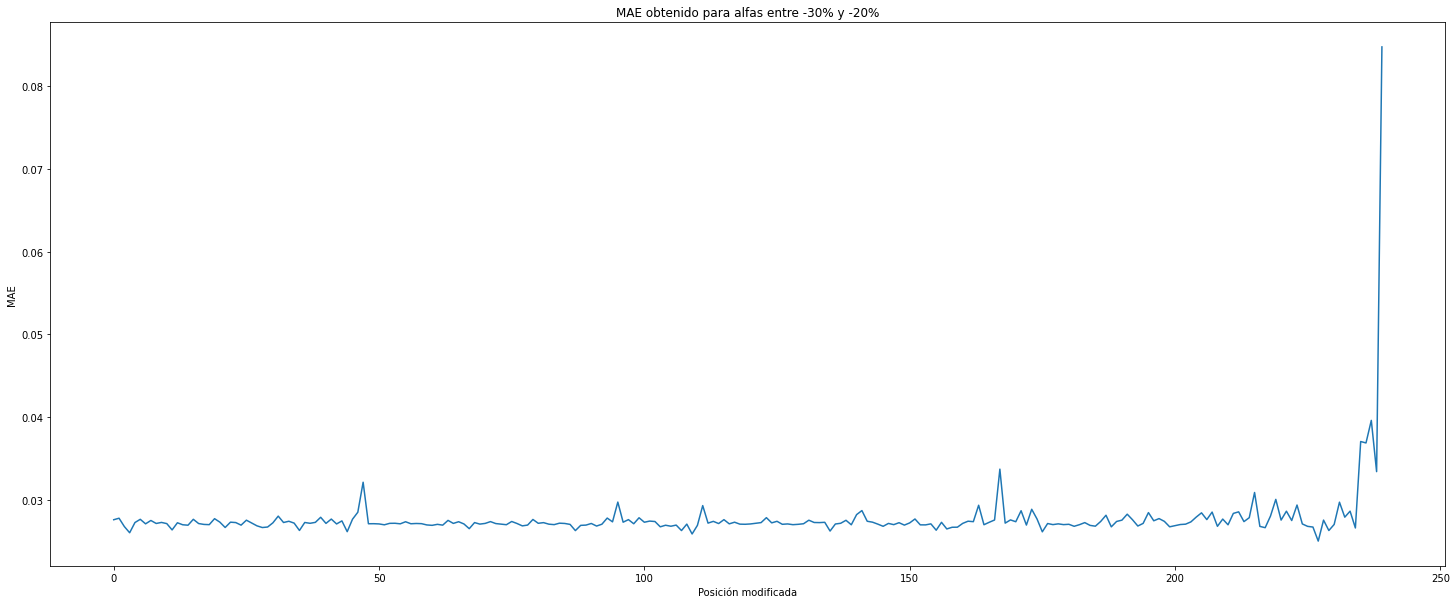

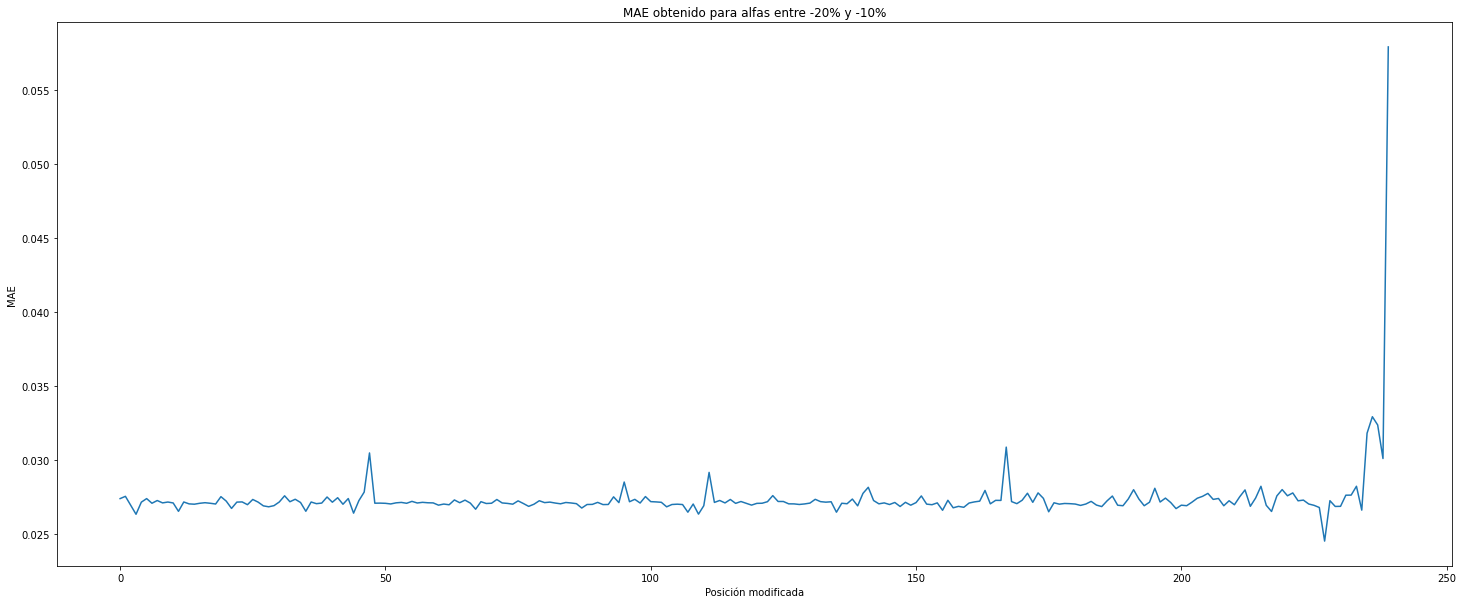

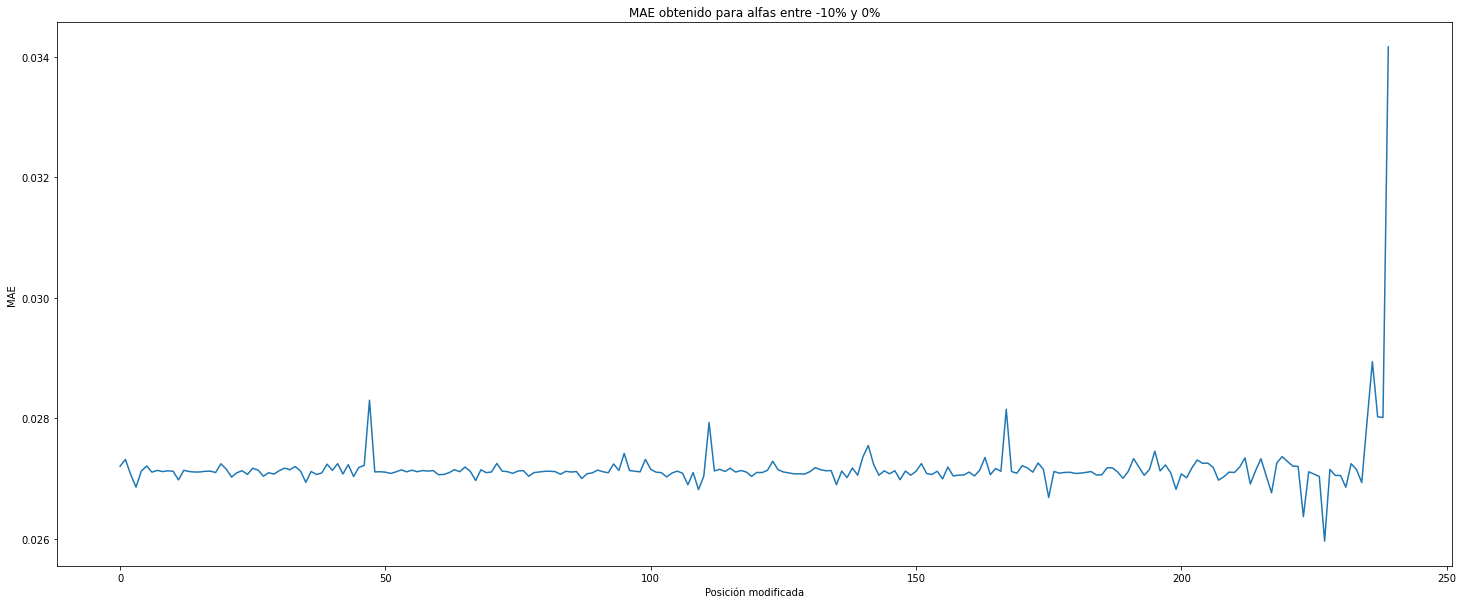

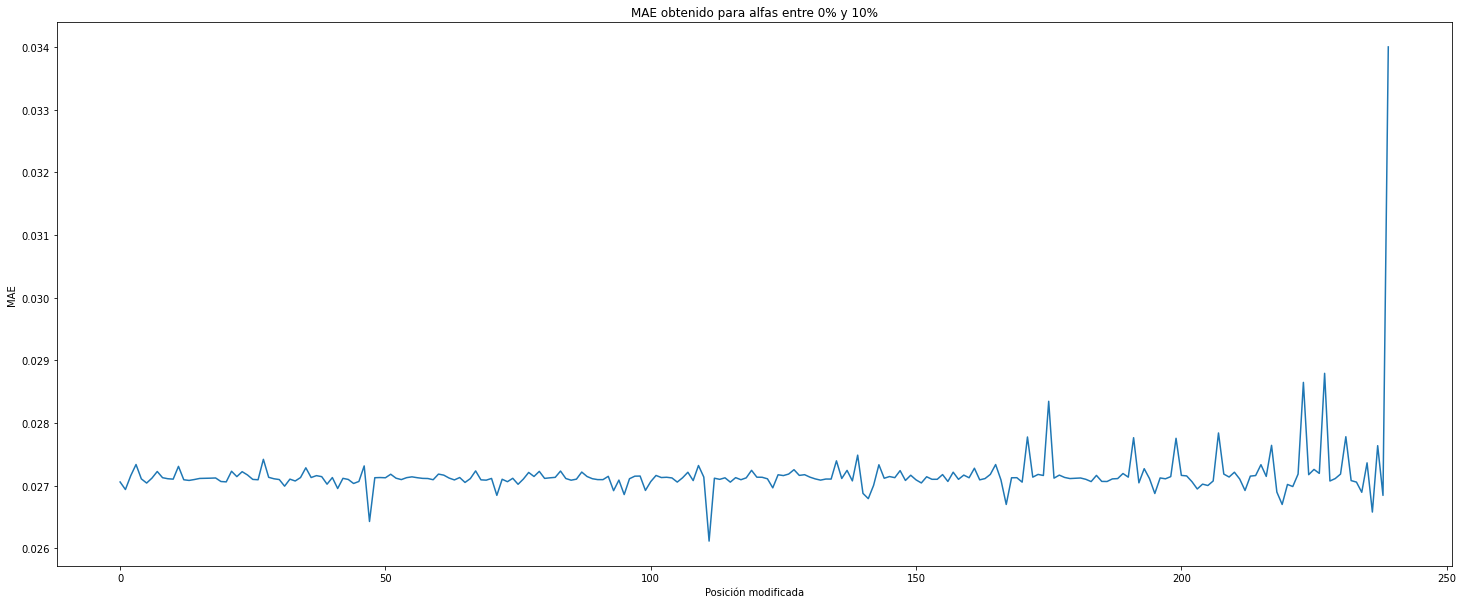

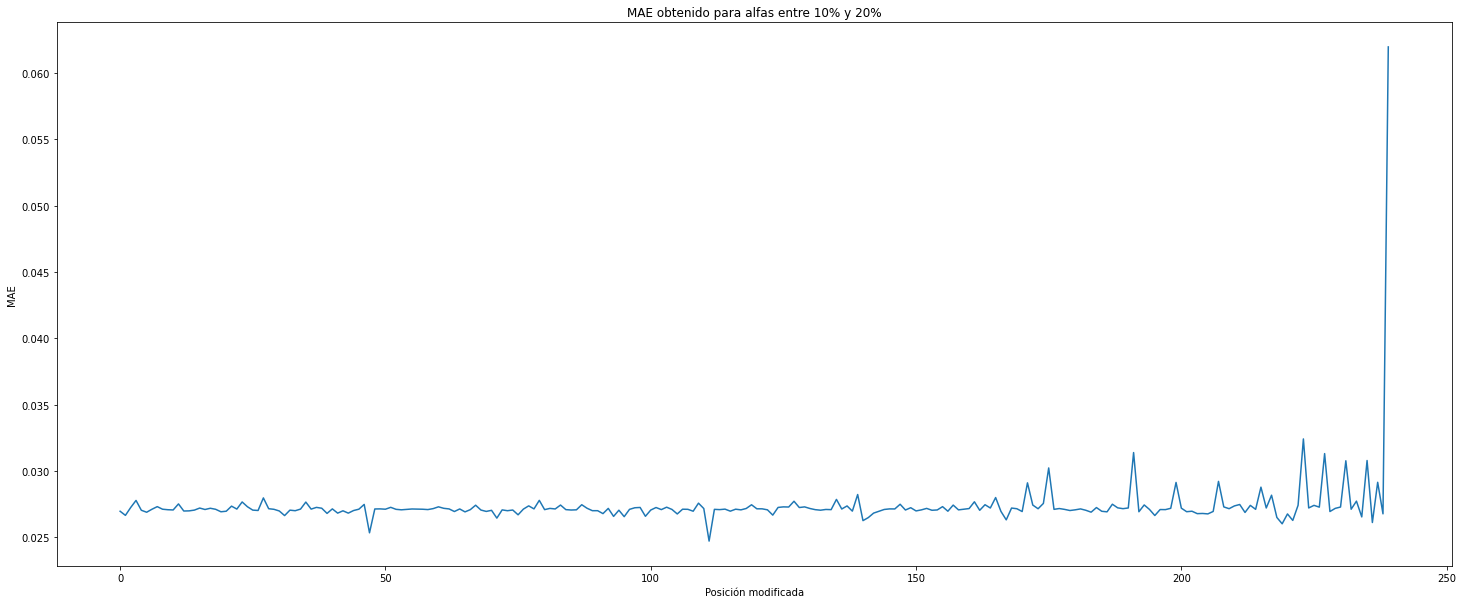

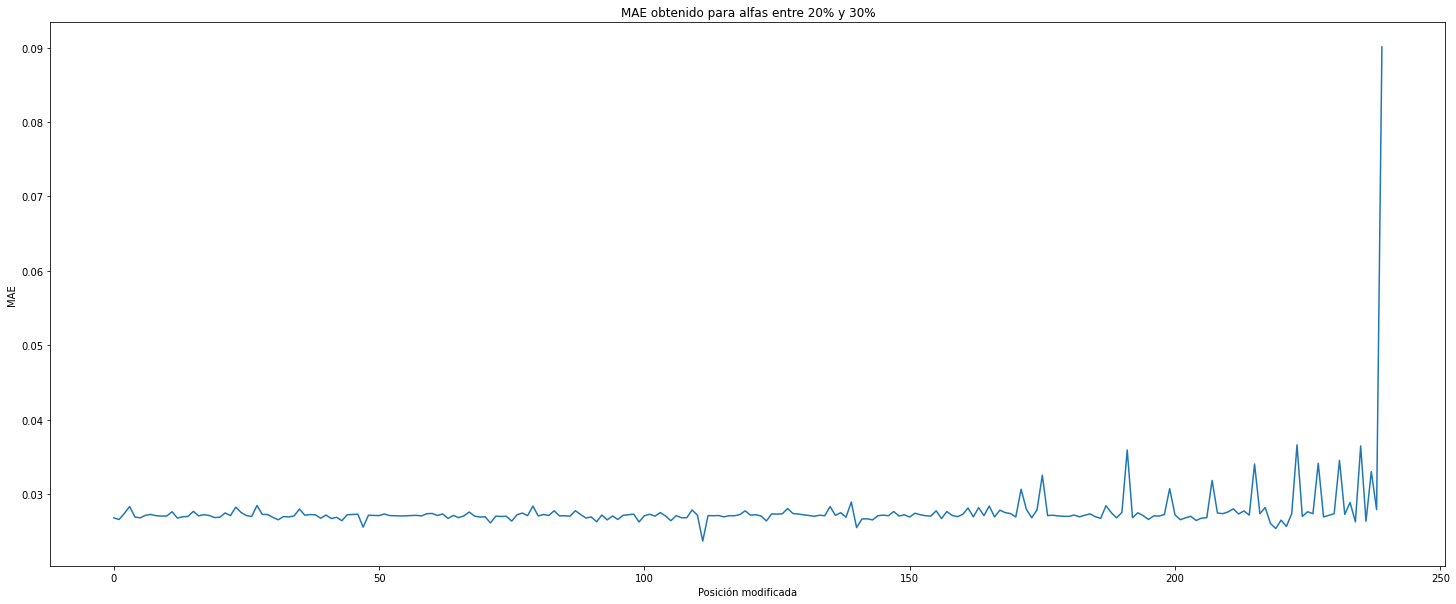

In [ ]:
for x in np.arange(-30,30,10):
  graf_lags_significativos(x, x + 10)

# Métodos de Regresión

## Regresión Lineal Simple

In [ ]:
alfas = []
for it in range(0, PH):
  alfas.append([])

for it in range(len(results['FACTOR'])):
  #if (results['FACTOR'][it] >= -0.25 and results['FACTOR'][it] <= 0.25):
  #if ((results['FACTOR'][it] >= -0.75 and results['FACTOR'][it] <= -0.25) or (results['FACTOR'][it] >= 0.25 and results['FACTOR'][it] <= 0.75)):
  #if (results['FACTOR'][it] <= -0.75 or results['FACTOR'][it] >= 0.75):
    alfas[results['DATO'][it]].append(results['FACTOR'][it])

maes = []
for it in range(0, PH):
  maes.append([])

for it in range(len(results['MAE'])):
  #if (results['FACTOR'][it] >= -0.25 and results['FACTOR'][it] <= 0.25):
  #if ((results['FACTOR'][it] >= -0.75 and results['FACTOR'][it] <= -0.25) or (results['FACTOR'][it] >= 0.25 and results['FACTOR'][it] <= 0.75)):
  #if (results['FACTOR'][it] <= -0.75 or results['FACTOR'][it] >= 0.75):
    maes[results['DATO'][it]].append(results['MAE'][it] - results['MAE'][0])

datos = pd.DataFrame({'alfas': alfas, 'maes': maes})
datos.head(100000)

,alfas,maes
0,"[0.0, -0.18, 0.78, -0.35, -0.35, -0.64, 0.64, ...","[0.0, -5.9000000003639474e-08, -5.900000000363..."
1,"[0.95, -0.35, 0.39, 0.18, -0.36, -0.03, -0.43,...","[-2.999999999808711e-08, -8.900000000172659e-0..."
2,"[0.55, -0.77, -0.17, 0.0, 0.11, 0.5, -0.73, 0....","[-2.999999999808711e-08, -2.999999999808711e-0..."
3,"[1.0, -0.2, 0.6, 0.93, -0.45, -0.76, -0.29, 0....","[-5.9000000003639474e-08, 0.0, -2.999999999808..."
4,"[0.28, -0.49, -0.74, 1.0, 0.56, 0.36, 0.01, -0...","[-2.999999999808711e-08, -8.900000000172659e-0..."
...,...,...
360,"[-0.22, 0.14, 0.99, 0.26, 0.22, 0.65, 0.83, -0...","[0.009449422999999998, 0.0009350480000000008, ..."
361,"[0.71, 0.9, 0.61, 0.09, 0.14, -0.54, 0.23, 1.0...","[0.0050148080000000025, 0.006366073999999999, ..."
362,"[-0.33, 0.01, -0.12, 0.44, -0.96, -0.35, -0.12...","[0.012012391999999997, 6.729400000000246e-05, ..."
363,"[0.29, 0.93, -0.48, 0.33, -0.33, -0.07, 0.47, ...","[0.001612335999999999, 0.0051883459999999965, ..."


In [ ]:
with open('/content/drive/MyDrive/Investigación/CSVs Experimentos estudio de lags/Experimento200Posiciones.csv', 'w') as csvfile:
  fieldnames = ['posicion', 'alfas', 'maes']
  writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

  writer.writeheader()
  for ij in range(0, 240):
    writer.writerow({'posicion': ij,
                     'alfas': alfas[ij],
                     'maes': maes[ij]})

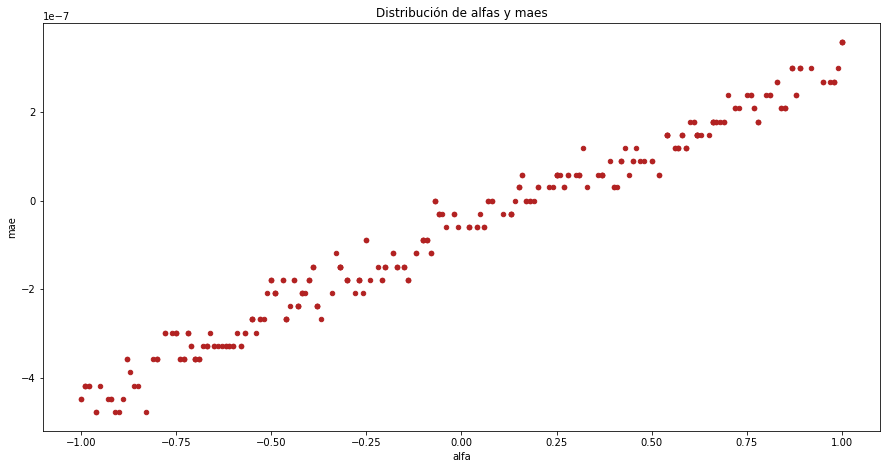

In [ ]:
# Gráfico
posicion = 300

data = pd.DataFrame({'alfa': alfas[posicion], 'mae': maes[posicion]})

fig, ax = plt.subplots(figsize=(15, 7.5))

data.plot(
    x    = 'alfa',
    y    = 'mae',
    c    = 'firebrick',
    kind = "scatter",
    ax   = ax
)
ax.set_title('Distribución de alfas y maes');

In [ ]:
# Correlación lineal entre las dos variables

corr_test = pearsonr(x = data['alfa'], y =  data['mae'])
print("Coeficiente de correlación de Pearson: ", corr_test[0])
print("P-value: ", corr_test[1])

Coeficiente de correlación de Pearson:  -0.9552197440614835
P-value:  1.8273643190421168e-156


### Scikit-learn

In [ ]:
# División de los datos en train y test
# ==============================================================================
X = data[['alfa']]
y = data['mae']

X_train, X_test, y_train, y_test = train_test_split(
                                        X.values.reshape(-1,1),
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

# Creación del modelo
# ==============================================================================
model = LinearRegression()
model.fit(X = X_train.reshape(-1, 1), y = y_train)

In [ ]:
# Información del modelo
# ==============================================================================
print("Intercept:", model.intercept_)
print("Coeficiente:", list(zip(X.columns, model.coef_.flatten(), )))
print("Coeficiente de determinación R^2:", model.score(X, y))

In [ ]:
# Error de test del modelo 
# ==============================================================================
predicciones = model.predict(X = X_test)
print(predicciones[0:3,])

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
      )
print("")
print(f"El error (rmse) de test es: {rmse}")

### Statsmodels

In [ ]:
# División de los datos en train y test
# ==============================================================================
X = data[['alfa']]
y = data['mae']

X_train, X_test, y_train, y_test = train_test_split(
                                        X.values.reshape(-1,1),
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [ ]:
# Creación del modelo utilizando el modo fórmula (similar a R)
# ==============================================================================
# datos_train = pd.DataFrame(np.hstack((X_train, y_train)), columns=['alfa', 'mae'])
# model = smf.ols(formula = 'runs ~bateos', data = datos_train)
# model = model.fit()
# print(modelo.summary())

In [ ]:
# Creación del modelo utilizando matrices como en scikitlearn
# ==============================================================================
# A la matriz de predictores se le tiene que añadir una columna de 1s para el intercept del modelo
X_train = sm.add_constant(X_train, prepend=True)
model = sm.OLS(endog=y_train, exog=X_train,)
model = model.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     636.6
Date:                Tue, 19 Jul 2022   Prob (F-statistic):           9.29e-22
Time:                        10:00:34   Log-Likelihood:                 223.41
No. Observations:                  32   AIC:                            -442.8
Df Residuals:                      30   BIC:                            -439.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003   4.17e-05      7.319      0.0

In [ ]:
# Intervalos de confianza para los coeficientes del modelo
# ==============================================================================
model.conf_int(alpha=0.05)

array([[0.00022029, 0.0003908 ],
       [0.00156919, 0.0018456 ]])

In [ ]:
# Predicciones con intervalo de confianza del 95%
# ==============================================================================
predicciones = model.get_prediction(exog = X_train).summary_frame(alpha=0.05)
predicciones.head(4)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,0.001893,0.000082,0.001727,0.002060,0.001391,0.002396
1,-0.001163,0.000065,-0.001296,-0.001030,-0.001655,-0.000670
2,0.000306,0.000042,0.000220,0.000391,-0.000176,0.000787
3,0.001996,0.000085,0.001822,0.002170,0.001491,0.002501


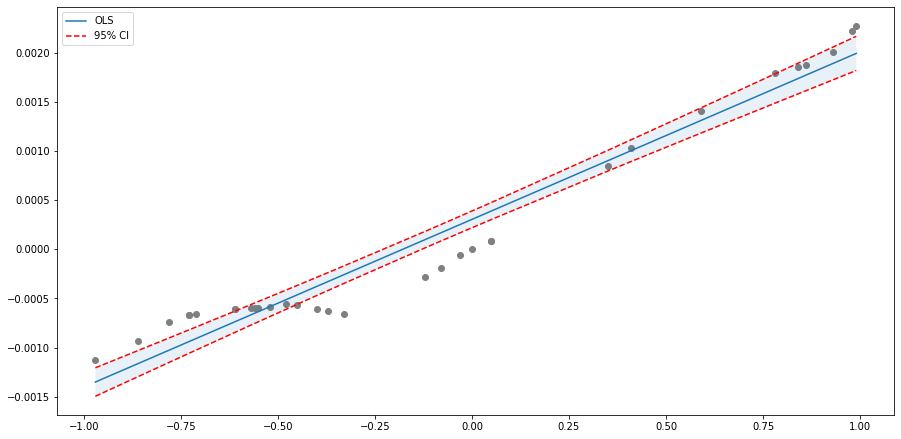

In [ ]:
# Predicciones con intervalo de confianza del 95%
# ==============================================================================
predicciones = model.get_prediction(exog = X_train).summary_frame(alpha=0.05)
predicciones['x'] = X_train[:, 1]
predicciones['y'] = y_train
predicciones = predicciones.sort_values('x')

# Gráfico del modelo
# ==============================================================================
fig, ax = plt.subplots(figsize=(15, 7.5))

ax.scatter(predicciones['x'], predicciones['y'], marker='o', color = "gray")
ax.plot(predicciones['x'], predicciones["mean"], linestyle='-', label="OLS")
ax.plot(predicciones['x'], predicciones["mean_ci_lower"], linestyle='--', color='red', label="95% CI")
ax.plot(predicciones['x'], predicciones["mean_ci_upper"], linestyle='--', color='red')
ax.fill_between(predicciones['x'], predicciones["mean_ci_lower"], predicciones["mean_ci_upper"], alpha=0.1)
ax.legend();

In [ ]:
# Error de test del modelo 
# ==============================================================================
X_test = sm.add_constant(X_test, prepend=True)
predicciones = model.predict(exog = X_test)
rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print("")
print(f"El error (rmse) de test es: {rmse}")


El error (rmse) de test es: 0.00018721517701660785


### Ejecución

In [ ]:
# Gráfico

def grafico (posicion, alfas, maes):
  data = pd.DataFrame({'alfa': alfas[posicion], 'mae': maes[posicion]})

  #fig, ax = plt.subplots(figsize=(15, 7.5))

  #data.plot(
      #x    = 'alfa',
      #y    = 'mae',
      #c    = 'firebrick',
      #kind = "scatter",
      #ax   = ax
  #)
  #ax.set_title('Distribución de alfas y maes');

  return data

In [ ]:
# Correlación lineal entre las dos variables

def correlacion(data):
  corr_test = pearsonr(x = data['alfa'], y =  data['mae'])
  #print("Coeficiente de correlación de Pearson: ", corr_test[0])
  #print("P-value: ", corr_test[1])

In [ ]:
def modeloScikitlearn(data):
  # División de los datos en train y test
  # ==============================================================================
  X = data[['alfa']]
  y = data['mae']

  X_train, X_test, y_train, y_test = train_test_split(
                                          X.values.reshape(-1,1),
                                          y.values.reshape(-1,1),
                                          train_size   = 0.8,
                                          random_state = 1234,
                                          shuffle      = True
                                      )

  # Creación del modelo
  # ==============================================================================
  model = LinearRegression()
  model.fit(X = X_train.reshape(-1, 1), y = y_train)

  # Información del modelo
  # ==============================================================================
  #print("Intercept:", model.intercept_)
  #print("Coeficiente:", list(zip(X.columns, model.coef_.flatten(), )))
  #print("Coeficiente de determinación R^2:", model.score(X, y))

  # Error de test del modelo 
  # ==============================================================================
  predicciones = model.predict(X = X_test)
  print(predicciones[0:3,])

  rmse = mean_squared_error(
          y_true  = y_test,
          y_pred  = predicciones,
          squared = False
        )
  #print("")
  #print(f"El error (rmse) de test es: {rmse}")

  return list(zip(X.columns, model.coef_.flatten(), ))

In [ ]:
def modeloStatsmodels(data, i):
  # División de los datos en train y test
  # ==============================================================================
  X = data[['alfa']]
  y = data['mae']

  X_train, X_test, y_train, y_test = train_test_split(
                                          X.values.reshape(-1,1),
                                          y.values.reshape(-1,1),
                                          train_size   = 0.8,
                                          random_state = 1234,
                                          shuffle      = True
                                      )

  # Creación del modelo utilizando matrices como en scikitlearn
  # ==============================================================================
  # A la matriz de predictores se le tiene que añadir una columna de 1s para el intercept del modelo
  X_train = sm.add_constant(X_train, prepend=True)
  model = sm.OLS(endog=y_train, exog=X_train,)
  model = model.fit()
  #print(model.summary())

  # Intervalos de confianza para los coeficientes del modelo
  # ==============================================================================
  model.conf_int(alpha=0.05)

  # Predicciones con intervalo de confianza del 95%
  # ==============================================================================
  predicciones = model.get_prediction(exog = X_train).summary_frame(alpha=0.05)
  predicciones.head(4)

  # Predicciones con intervalo de confianza del 95%
  # ==============================================================================
  predicciones = model.get_prediction(exog = X_train).summary_frame(alpha=0.05)
  predicciones['x'] = X_train[:, 1]
  predicciones['y'] = y_train
  predicciones = predicciones.sort_values('x')

  # Gráfico del modelo
  # ==============================================================================
  fig, ax = plt.subplots(figsize=(15, 7.5))

  ax.scatter(predicciones['x'], predicciones['y'], marker='o', color = "gray")
  ax.plot(predicciones['x'], predicciones["mean"], linestyle='-', label="OLS")
  ax.plot(predicciones['x'], predicciones["mean_ci_lower"], linestyle='--', color='red', label="95% CI")
  ax.plot(predicciones['x'], predicciones["mean_ci_upper"], linestyle='--', color='red')
  ax.fill_between(predicciones['x'], predicciones["mean_ci_lower"], predicciones["mean_ci_upper"], alpha=0.1)
  ax.set_title('Distribución de alfas y maes, posición {0}'.format(i))
  ax.legend();

  # Error de test del modelo 
  # ==============================================================================
  X_test = sm.add_constant(X_test, prepend=True)
  predicciones = model.predict(exog = X_test)
  rmse = mean_squared_error(
          y_true  = y_test,
          y_pred  = predicciones,
          squared = False
        )
  #print("")
  #print(f"El error (rmse) de test es: {rmse}")

In [ ]:
# Ejecución
pendientes = []

for it in range(0, PH):
  data = grafico(it, alfas, maes)
  correlacion(data)
  pendiente = modeloScikitlearn(data)
  #pendiente = modeloStatsmodels(data, it)
  pendientes.append(pendiente[0][1])


In [ ]:
#Registro

with open('/content/drive/MyDrive/Investigación/CSVs Experimentos estudio de lags/Experimento25PendientePequeña.csv', 'w') as csvfile:
  fieldnames = ['posicion', 'pendiente']
  writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

  writer.writeheader()
  for ij in range(0, 240):
    writer.writerow({'posicion': ij,
                     'pendiente': pendientes[ij]})

In [ ]:
pendientes = []

# Read training set
filename = '/content/drive/MyDrive/Investigación/CSVs Experimentos estudio de lags/Experimento 24/Experimento24PendientePequeña.csv'
datos = pd.read_csv(filename, sep=',')
datos = datos.set_index('posicion')

for ij in range(len(datos)):
  pendientes.append(abs(datos['pendiente'][ij]))

PH = 240 # 240
FH = 24 # 24

iterations = len(datos)

In [ ]:
pend = []

for k in pendientes:
  pend.append(abs(k))

pend.sort(reverse=True)
top_diez = pend[:10]
print(top_diez)

for k in top_diez:
  if k in pendientes:
    print(str(pendientes.index(k)) + " +")
  else:
    print(str(pendientes.index(-k)) + " -")

In [ ]:
for k in range(11):
  print(24*k)

## Regresión No Lineal

In [ ]:
alfas = []
for it in range(len(results['FACTOR'])):
  alfas.append(results['FACTOR'][it])

alfas.pop(0)

maes = []
for it in range(len(results['MAE'])):
  maes.append(results['MAE'][it] - results['MAE'][0])

maes.pop(0)

datos = pd.DataFrame({'alfa': alfas, 'mae': maes})
datos.head(100000)

,alfa,mae
0,0.45,0.000956
1,0.95,-0.000270
2,-0.35,-0.000008
3,0.26,0.000358
4,0.15,0.000004
...,...,...
9994,-0.65,-0.000216
9995,0.39,0.001162
9996,-0.77,0.001003
9997,-0.21,-0.000048


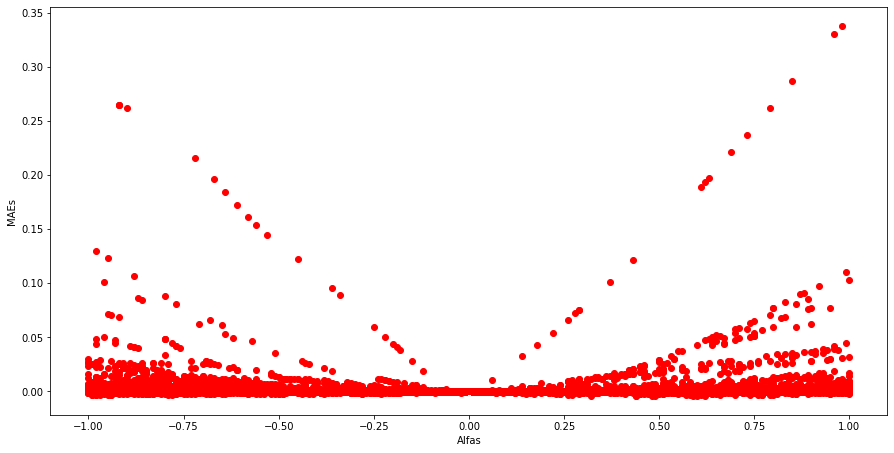

In [ ]:
# Gráfico

plt.figure(figsize=(15,7.5))
x_data, y_data = (datos["alfa"].values, datos["mae"].values)
plt.plot(x_data, y_data, 'ro')
plt.ylabel('MAEs')
plt.xlabel('Alfas')
plt.show()

In [ ]:
#define el modelo

def sigmoid(x, Beta_1, Beta_2):
     y = Beta_1 * np.power(x - Beta_2,2)
     return y

In [ ]:
xdata =x_data/max(x_data)
ydata =y_data/max(y_data)

from scipy.optimize import curve_fit
popt, pcov = curve_fit(sigmoid, xdata, ydata, maxfev=5000)
#imprimir los parámetros finales
print(" beta_1 = %f, beta_2 = %f" % (popt[0], popt[1]))

 beta_1 = 0.000000, beta_2 = 1918.236796


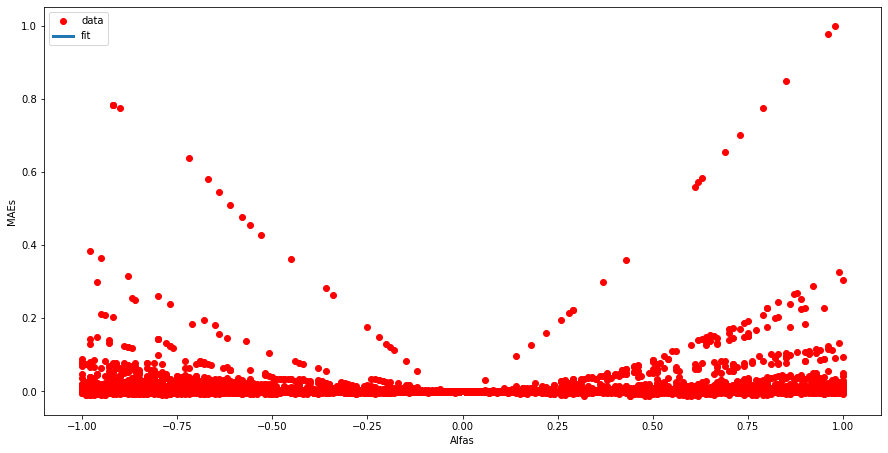

In [ ]:
x = np.linspace(-100, 100, 1)
x = x/max(x)
plt.figure(figsize=(15,7.5))
y = sigmoid(x, *popt)
plt.plot(xdata, ydata, 'ro', label='data')
plt.plot(x,y, linewidth=3.0, label='fit')
plt.legend(loc='best')
plt.ylabel('MAEs')
plt.xlabel('Alfas')
plt.show()

In [ ]:
# divide los datos en entrenamiento y prueba
msk = np.random.rand(len(datos)) < 0.8
train_x = xdata[msk]
test_x = xdata[~msk]
train_y = ydata[msk]
test_y = ydata[~msk]

# construye el modelo utilizando el set de entrenamiento
popt, pcov = curve_fit(sigmoid, train_x, train_y, maxfev=5000)

# predecir utilizando el set de prueba
y_hat = sigmoid(test_x, *popt)

# evaluation
print("Promedio de error absoluto: %.2f" % np.mean(np.absolute(y_hat - test_y)))
print("Suma residual de cuadrados (MSE): %.2f" % np.mean((y_hat - test_y) ** 2))
from sklearn.metrics import r2_score
print("R2-score: %.2f" % r2_score(y_hat , test_y) )

Promedio de error absoluto: 0.01
Suma residual de cuadrados (MSE): 0.00
R2-score: -195314.69
